In [1]:
! pip install numpy==1.22.4 -q
! pip install phik==0.12.4 -q
! pip install shap==0.44.0 -q
! pip install scikit-learn==1.5.0 -q

import math
import  pandas as pd 
import  numpy as np
import  matplotlib.pyplot as plt
import  seaborn as sns


from  sklearn.model_selection import   (train_test_split,
                                        RandomizedSearchCV)
from  sklearn.preprocessing   import   (OneHotEncoder,
                                        OrdinalEncoder,
                                        StandardScaler,
                                        MinMaxScaler,
                                        LabelEncoder,
                                        PolynomialFeatures)
from  sklearn.metrics         import    (roc_auc_score,
                                        RocCurveDisplay)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

from phik import phik_matrix
import shap
import warnings
warnings.filterwarnings("ignore") # игнорирование предупреждений

pd.set_option('display.max_colwidth', None) #для полного отображения строки в датафрейме
pd.set_option('display.max_columns',  None) # для отображения макс.количества столбцов
RANDOM_STATE = 42 # переменная для фиксирования случайности
TEST_SIZE = 0.25 # доля тестовой выборки

*Примечание: работа выполнена в JupyterLab со встроенным toc, которая входит в виртуальное окружение для всех проектов Яндекс-Практикума. Слева в нем есть вкладка Table of Content. В ней автоматически формируется структура документа в зависимости от Markdown-заголовков.*

# Исследование данных интернет-магазина и формирование персонализированных предложений

## Описание данных и цели проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов.                            
**Сделать это можно с помощью персонализированных предложений.**    

Продумывать **подход к решению задачи** вам не придётся — руководитель отдела его уже сформировал:           
1.	Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».             
2.	Нужно собрать данные по клиентам по следующим группам:          
* Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
* Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
* Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
* Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.          

**Требования заказчика:**     
1.	Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.          
2.	В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.   
3.	Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.          


Данные для работы находятся в нескольких таблицах.     
**market_file.csv**         
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.            
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.            

**market_money.csv**       
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.          
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.           

**market_time.csv**               
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.              
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.                

**money.csv**                 
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.              
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.                  

## Знакомство с данными

### Считывание данных из файлов

**Считываем данные из csv-файлов в датафреймы и сохраним в переменные market_file, market_money, market_time, money.   
Пути к файлам:**   
- /datasets/market_file.csv - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.     
- /datasets/market_money.csv - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.       
- /datasets/market_time.csv - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.          
- /datasets/money.csv - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.      

In [2]:
# считываем csv-файлы
try:
    market_file = pd.read_csv('market_file.csv')
    market_money = pd.read_csv('market_money.csv')
    market_time = pd.read_csv('market_time.csv')
    money = pd.read_csv('money.csv', sep=';')
except:
    try:
        market_file = pd.read_csv('/datasets/market_file.csv')
        market_money = pd.read_csv('/datasets/market_money.csv')
        market_time = pd.read_csv('/datasets/market_time.csv')
        money = pd.read_csv('/datasets/money.csv', sep=';')
    except:
        market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
        market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
        market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
        money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

### Общая информация

#### Датафрейм "market_file"

**Выведем первые 5 строчек датафрейма `market_file` и общую информацию о нем.**

In [3]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Вывод:**
- **В датафрейме `market_file` нет пропущенных значений.**
- **В таблице содержится 1300 строк (от 0 до 1299) - данные о поведении покупателей на сайте, о коммуникациях с покупателем и его продуктовом поведении.**
- **В таблице содержится 13 столбцов. Наименования столбцов содержат латинские (столбец "id") и кириллические символы, а также специальные символы в виде пробела.**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.**
- **Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов не соответствуют "змеиному" стилю, изменим на змеиный стиль.**
- **Вес датафрейма небольшой: 132.2 kb.**
- **Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.**
- **Также необходимо проверить данные на дубликаты. Видим, что в столбце с типом сервиса, вероятно, присутствуют неявные дубликаты.**

#### Датафрейм "market_money"

**Выведем первые 5 строчек датафрейма `market_money` и общую информацию о нем.**

In [5]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Вывод:**
- **В датафрейме `market_money` нет пропущенных значений.**
- **В таблице содержится 3900 строк (от 0 до 3899) - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.**
- **В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (другие столбцы).**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.**
- **Вес датафрейма небольшой: 91.5 kb.**
- **Далее данные будут проверены на явные и неявные дубликаты.**

#### Датафрейм "market_time"

**Выведем первые 5 строчек датафрейма `market_time` и общую информацию о нем.**

In [7]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Вывод:**
- **В датафрейме `market_time` нет пропущенных значений.**
- **В таблице содержится 2600 строк (от 0 до 2599) - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.**
- **В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (остальные столбцы).**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.**
- **Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов в разном стиле: есть с заглавной, есть со строчной буквы.**
- **Вес датафрейма небольшой: 61.1 kb.**
- **Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.**
- **Также необходимо проверить данные на явные и неявные дубликаты. Видим, что в столбце с периодом либо опечатки, либо неявные дубликаты. Этот столбец надо привести в соответствие со столбцом "Период" в датафрейме "market_money".**

#### Датафрейм "money"

**Выведем первые 5 строчек датафрейма `money` и общую информацию о нем.**

In [9]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [10]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


**Вывод:**
- **В датафрейме `money` нет пропущенных значений.**
- **В таблице содержится 1300 строк (от 0 до 1299) - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.**
- **В таблице содержится 2 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (столбец "Прибыль").**
- **Так как идентификаторы принято обозначать "id", оставим как есть, а другой столбец ("Прибыль") оставим с кириллическими символами.**
- **Типы данных в колонке с прибылью необходимо привести к числовому типу.**
- **Вес датафрейма небольшой: 20.4 kb.**

### Промежуточный вывод по общей информации о датафреймах

**Датафрейм `market_file`:**
- В датафрейме `market_file` нет пропущенных значений.
- В таблице содержится 1300 строк (от 0 до 1299) - данные о поведении покупателей на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- В таблице содержится 13 столбцов. Наименования столбцов содержат латинские (столбец "id") и кириллические символы, а также специальные символы в виде пробела.
- Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.
- Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов не соответствуют "змеиному" стилю, изменим на змеиный стиль.
- Вес датафрейма небольшой: 132.2 kb.
- Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.
- Также необходимо проверить данные на дубликаты. Видим, что в столбце с типом сервиса, вероятно, присутствуют неявные дубликаты.

**Датафрейм `market_money`:**
- В датафрейме `market_money` нет пропущенных значений.
- В таблице содержится 3900 строк (от 0 до 3899) - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (другие столбцы).
- Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.
- Вес датафрейма небольшой: 91.5 kb.
- Далее данные будут проверены на явные и неявные дубликаты.

**Датафрейм `market_time`:**
- В датафрейме `market_time` нет пропущенных значений.
- В таблице содержится 2600 строк (от 0 до 2599) - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- В таблице содержится 3 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (остальные столбцы).
- Так как идентификаторы принято обозначать "id", оставим как есть, а другие столбы оставим с кириллическими символами.
- Наименования столбцов не соответствует общепринятым стандартам оформления данных, названия столбцов в разном стиле: есть с заглавной, есть со строчной буквы.
- Вес датафрейма небольшой: 61.1 kb.
- Типы данных в целочисленных колонках не оптимальны. Ввиду небольшого размера датафрейма оставим как есть.
- Также необходимо проверить данные на явные и неявные дубликаты. Видим, что в столбце с периодом либо опечатки, либо неявные дубликаты. Этот столбец надо привести в соответствие со столбцом "Период" в датафрейме "market_money".

**Датафрейм `money`:**
- В датафрейме `money` нет пропущенных значений.
- В таблице содержится 1300 строк (от 0 до 1299) - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- В таблице содержится 2 столбца. Наименования столбцов содержат латинские (столбец "id") и кириллические символы (столбец "Прибыль").
- Так как идентификаторы принято обозначать "id", оставим как есть, а другой столбец ("Прибыль") оставим с кириллическими символами.
- Типы данных в колонке с прибылью необходимо привести к числовому типу.
- Вес датафрейма небольшой: 20.4 kb.

## Предобработка данных

### Переименование столбцов

В датафрейме "market_file" названия не соответствуют змеиному стилю, исправим это. Также сделаем все названия столбцов со строчной буквы для всех датафреймов. Создадим для этого функцию.

In [11]:
"""
На вход функции поступает датафрейм, в котором будут обрабатываться названия столбцов.
В функции применяется list comprehension.
Метод strip() - для удаления пробелов слева и справа,
lower() -  для нижнего регистра, метод strip() - для получения списка из строки,
'_'.join() - для объединения элементов списка в строку
Функция возвращает новые названия столбцов
"""
def columns_names_func(df):
    columns_names = [col.strip().lower().split() for col in df.columns]
    columns_names = ['_'.join(col) for col in columns_names]
    return columns_names

In [12]:
# переименование столбцов в датафрейме market_file
market_file.columns = columns_names_func(market_file)
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [13]:
# переименование столбцов в датафрейме market_money
market_money.columns = columns_names_func(market_money)
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [14]:
# переименование столбцов в датафрейме market_time
market_time.columns = columns_names_func(market_time)
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [15]:
# переименование столбцов в датафрейме money
money.columns = columns_names_func(money)
money.columns

Index(['id', 'прибыль'], dtype='object')

### Обработка неправильных разделитей десятичных значений

In [16]:
money.head(3)

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"


Ранее было обнаружено, что в датафрейме "money" в столбце "прибыль" в качестве разделителя десятичных значений используется запятая вместо точки. Исправим это.

In [17]:
# заменим запятые на точки в столбце "прибыль" датафрейма money
money["прибыль"] = money["прибыль"].str.replace(',','.').astype('float')
money.head(3)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


### Обработка дубликатов и опечаток

Проверим наличие явных и неявных дубликатов в датафреймах.

In [18]:
"""
На вход функции подается датафрейм.
Функция выводит результат в виде таблицы: для всех категориальных столбцов их уникальные значения.
"""
def unique_column(df):
    rez = []
    #добавляем в список кортеж из названий всех категориальных столбцов и их уникальных значений
    for col in df.select_dtypes(exclude='number').columns.tolist():
        rez.append((col, df[col].unique()))
    if rez==[]:
        return 'В датафрейме нет категориальных столбцов'
    else:
        display(pd.DataFrame(rez, columns=['Категориальные столбцы', 'Уникальные значения']).set_index('Категориальные столбцы'))

In [19]:
# отобразить уникальные значения категориальных столбцов датафрейма market_file
unique_column(market_file)

,Уникальные значения
Категориальные столбцы,
покупательская_активность,"[Снизилась, Прежний уровень]"
тип_сервиса,"[премиум, стандартт, стандарт]"
разрешить_сообщать,"[да, нет]"
популярная_категория,"[Товары для детей, Домашний текстиль, Косметика и аксесуары, Техника для красоты и здоровья, Кухонная посуда, Мелкая бытовая техника и электроника]"


In [20]:
# отобразить уникальные значения категориальных столбцов датафрейма market_money
unique_column(market_money)

,Уникальные значения
Категориальные столбцы,
период,"[препредыдущий_месяц, текущий_месяц, предыдущий_месяц]"


In [21]:
# отобразить уникальные значения категориальных столбцов датафрейма market_time
unique_column(market_time)

,Уникальные значения
Категориальные столбцы,
период,"[текущий_месяц, предыдцщий_месяц]"


In [22]:
# отобразить уникальные значения категориальных столбцов датафрейма money
unique_column(money)

'В датафрейме нет категориальных столбцов'

**Обнаружены следующие проблемы:** 
* Заменим неявный дубликат "стандартт" на "стандарт" в столбце "тип_сервиса" датафрейма "market_file".
* Исправим опечатку в слове аксессуары в  столбце "популярная_категория" датафрейма "market_file".
* Исправим опечатку в слове "предыдцщий_месяц" в столбце "период" датафрейма market_time.

In [23]:
# делаем замену 'стандартт' на 'стандарт'
market_file['тип_сервиса'] = market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
# выводим уникальные значения
display(market_file['тип_сервиса'].unique())
# исправим опечатку в слове аксессуары
market_file['популярная_категория'] = market_file['популярная_категория'].str.replace('Косметика и аксесуары', 'Косметика и аксессуары')
# выводим уникальные значения
display(market_file['популярная_категория'].unique())  
market_time['период'] = market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
# выводим уникальные значения
market_time['период'].unique()  

array(['премиум', 'стандарт'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

**Неяные дубликаты и опечатки устранены. Проверим явные дубликаты.**

In [24]:
 # подсчёт явных дубликатов
(market_file.duplicated().sum(),
market_money.duplicated().sum(),
market_time.duplicated().sum(),
money.duplicated().sum())

(0, 0, 0, 0)

**Вывод":**         
* В датафрейме "market_file" неявные дубликаты в столбце "тип_сервиса" обработаны.
* В датафрейме "market_file" опечатки в столбце "популярная_категория" исправлены.
* В датафрейме "market_time" опечатки в столбце "период" исправлены.
* Явные дубликаты во всех датафреймах не обнаружены.

### Поиск и устранение явных аномалий

**Для поиска явных аномалий построим диаграммы, на которых отчетливо видно, в каком числовом диапазоне находятся числовые колонки.**

#### Датафрейм "market_file"

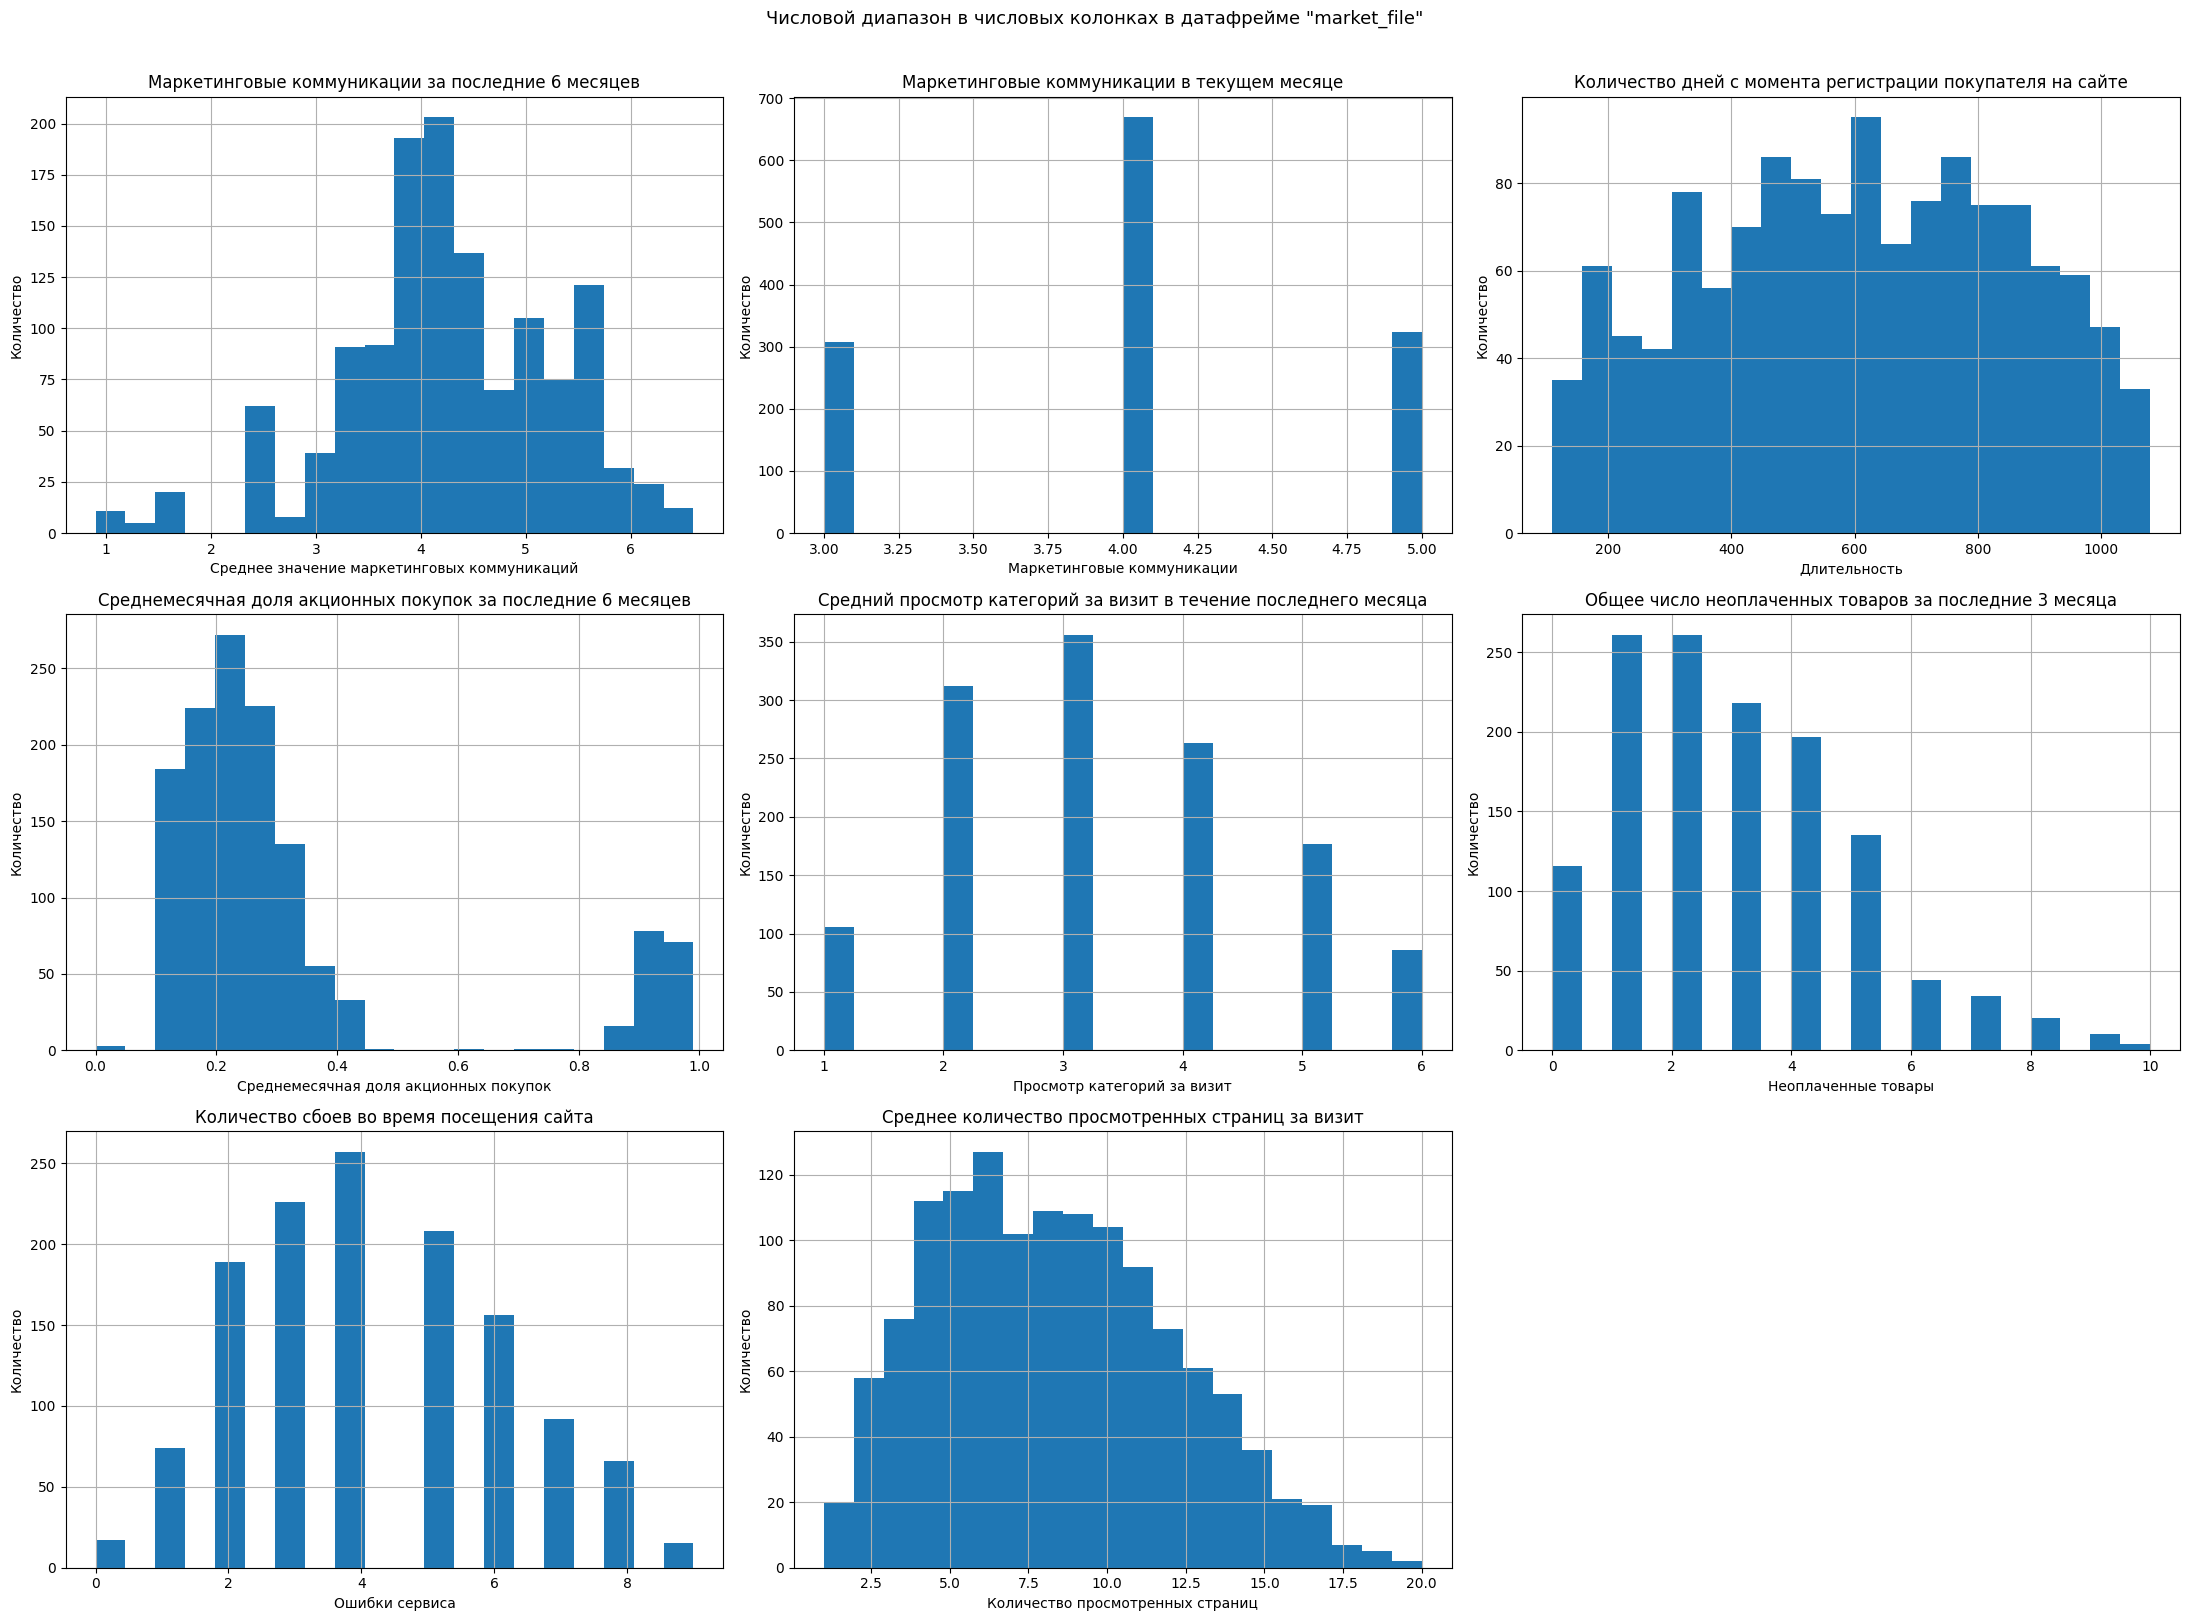

In [25]:
# строим гистограммы в числовых колонках
axes = market_file.drop(columns='id').hist(figsize=(22,16), bins=20);

# Общий заголовок для всех колонок
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "market_file"', fontsize=13, y=1.01);
# списки для заголовков и подписей осей
titles = [
    'Маркетинговые коммуникации за последние 6 месяцев', 
    'Маркетинговые коммуникации в текущем месяце',
    'Количество дней с момента регистрации покупателя на сайте', 
    'Среднемесячная доля акционных покупок за последние 6 месяцев', 
    'Средний просмотр категорий за визит в течение последнего месяца',
    'Общее число неоплаченных товаров за последние 3 месяца',
    'Количество сбоев во время посещения сайта',
    'Среднее количество просмотренных страниц за визит',
    ''
]
xlabel = [
    'Среднее значение маркетинговых коммуникаций',
    'Маркетинговые коммуникации',
    'Длительность',
    'Среднемесячная доля акционных покупок',
    'Просмотр категорий за визит',
    'Неоплаченные товары',
    'Ошибки сервиса',
    'Количество просмотренных страниц',
    '']
ylabel = ['Количество']*9
"""
axes - массив numpy.ndarray размером (3,2)
axes.flat - это аттрибут numpy.ndarray,  одномерный итератор по массиву,
используется для перебора всех осей из массива осей (в нашем случае осей (3,2))
Это позволяет использовать 1 цикл.
Альтернатива - axes.flatten(), где flatten() - метод массива numpy. Вместо
итератора возвращает уменьшенную версию массива. Снаружи между ними нет никакой разницы.
Однако итератор фактически не создает новый массив и может быть немного быстрее.
"""
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i]);
    ax.set_xlabel(xlabel[i]);
    ax.set_ylabel(ylabel[i]);

# чтобы оси не пересекались с соседними графиками
plt.tight_layout();

**Датафрейм "market_file":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* Аномальных данных не обнаружено.
* Признаки "маркетинговые коммуникации в течение месяца", "средний просмотр категорий за визит", "число неоплаченных товаров за последние 3 месяца", "количество сбоев во время посещения сайта" имеют ярко выраженные дискретные значения, для них подойдет столбиковая диаграмма. 

#### Датафрейм "market_time"

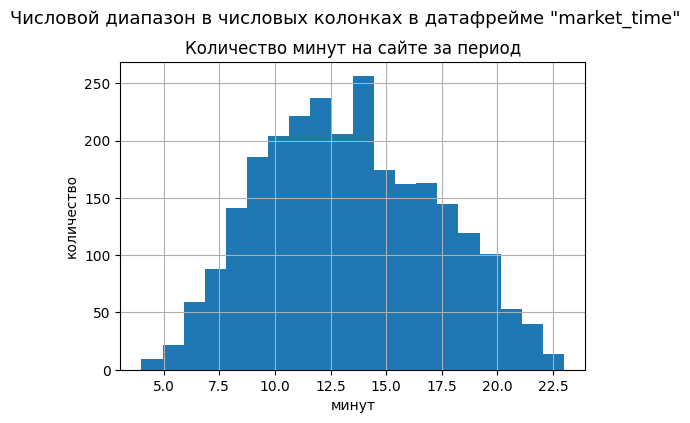

In [26]:
market_time.drop(columns='id').hist(figsize=(6,4), bins=20);
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "market_time"', fontsize=13, y=1.01);
plt.title('Количество минут на сайте за период');
plt.xlabel('минут')
plt.ylabel('количество');

**Датафрейм "market_time":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* Аномальных данных не обнаружено.
* Исследовательский анализ признаков будет проведен далее. 

#### Датафрейм "market_money"

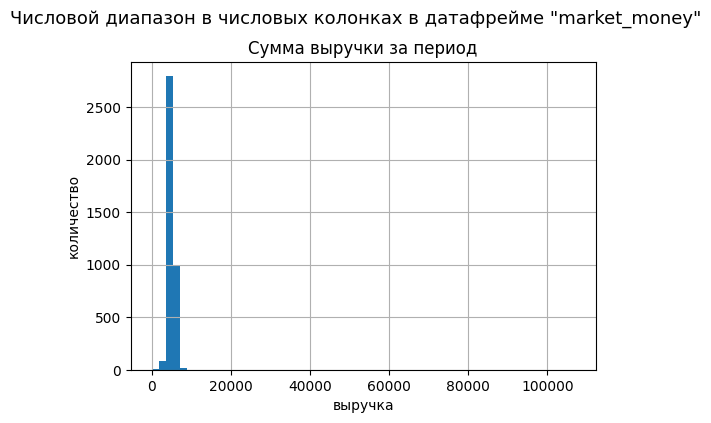

In [27]:
# построение гистограмм для всех числовых колонок в поиске аномалий
market_money.drop(columns='id').hist(figsize=(6,4), bins=60);
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "market_money"', fontsize=13, y=1.01);
plt.title('Сумма выручки за период');
plt.xlabel('выручка')
plt.ylabel('количество');

**Датафрейм "market_money":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* По шкале абсцисс видно, что **есть аномальные данные, превышающие общемассовые значения.**
* Исследовательский анализ признаков будет проведен далее. 

**Посмотрим на аномальные данные и их количество.**

In [28]:
# выводим аномальные данные с помощью логической индексации
market_money[market_money['выручка']>=20_000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


**Запомним id в строке с аномальными данными для того, чтобы удалить этого покупателя из других таблиц.**

In [29]:
# id_del - это id покупателя с аномальной выручкой
id_del = market_money[market_money['выручка']>=20_000].loc[98,'id']
id_del

215380

**Посмотрим, сколько строк в датафрейме market_money с данным покупателем.**

In [30]:
market_money['id'].isin([id_del]).sum()

3

**Посмотрим, содержат ли остальные таблицы клиента с данным номером id (id_del).**

In [31]:
money['id'].isin([id_del]).sum()

1

In [32]:
market_time['id'].isin([id_del]).sum()

2

In [33]:
market_file['id'].isin([id_del]).sum()

1

**Удалим покупателя с аномально большой выручкой из всех таблиц (так как это будет мешать нам строить модели машинного обучения).**

In [34]:
# удаляем аномальные данные с помощью логической индексации
market_money = market_money[~market_money['id'].isin([id_del])].reset_index(drop=True)
money = money[~money['id'].isin([id_del])].reset_index(drop=True)
market_time = market_time[~market_time['id'].isin([id_del])].reset_index(drop=True)
market_file = market_file[~market_file['id'].isin([id_del])].reset_index(drop=True)
(
    market_money['id'].isin([id_del]).sum(),
    money['id'].isin([id_del]).sum(), 
    market_time['id'].isin([id_del]).sum(), 
    market_file['id'].isin([id_del]).sum()
)

(0, 0, 0, 0)

**Покупатель с аномально большой выручкой удален из всех таблиц.**

**Посмотрим на изменившуюся размерность датафреймов.**

In [35]:
market_file.shape

(1299, 13)

In [36]:
market_time.shape

(2598, 3)

In [37]:
market_money.shape

(3897, 3)

In [38]:
money.shape

(1299, 2)

#### Датафрейм "money"

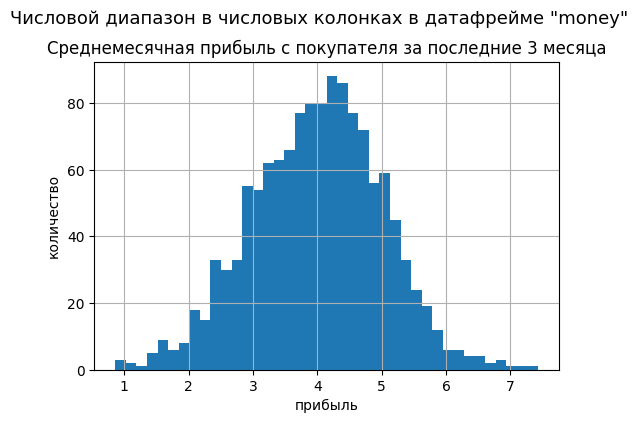

In [39]:
# построение гистограмм для всех числовых колонок в поиске аномалий
money.drop(columns='id').hist(figsize=(6,4), bins=40);
plt.suptitle('Числовой диапазон в числовых колонках в датафрейме "money"', fontsize=13, y=1.01);
plt.title('Среднемесячная прибыль с покупателя за последние 3 месяца');
plt.xlabel('прибыль')
plt.ylabel('количество');

**Датафрейм "money":**          
**По масштабам шкал гистограмм (ось абсцисс) видно, есть ли аномалии либо выбросы в данных.** 
* Аномальных данных не обнаружено.
* Исследовательский анализ признаков будет проведен далее. 

### Промежуточный вывод по предобработке данных

**В ходе предобработки данных были устранены следующие проблемы:**
* В датафрейме "market_file" названия приведены к змеиному стилю.
* Для всех датафреймов все названия столбцов приведены к нижнему регистру.
* В датафрейме "money" в столбце "прибыль" в качестве разделителя десятичных значений исправлена ошибка: поставлена точка вместо запятой. Соответсвенно тип данных изменен на float.
* В датафрейме "market_file" неявные дубликаты в столбце "тип_сервиса" обработаны.
* В датафрейме "market_file" опечатки в столбце "популярная_категория" исправлены.
* В датафрейме "market_time" опечатки в столбце "период" исправлены.
* В датафрейме  "market_money" найден покупатель с аномально большой выручкой. Данный покупатель был удален из вех таблиц. В результате этой операции таблицы "market_file" и "money" уменьшились на одну строку, таблица "market_time" - на 2 строки, таблица "market_money" - на 3 строки.    
Явные дубликаты во всех датафреймах не обнаружены.

## Отбор клиентов с покупательской активностью не менее трёх месяцев

**По техническому заданию требуется разработать модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.** 

**Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.** 

In [40]:
# выведем покупателей, которые не были активны в течение всех трех месяцев
market_money.loc[market_money['выручка'] == 0]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [41]:
# id неактивных покупателей
id_not_active = market_money.loc[market_money['выручка'] == 0]['id'].unique()
id_not_active

array([215348, 215357, 215359], dtype=int64)

**У нас в базе 3 покупателя, которые не имеют покупок в какой-либо из 3 месяцев. Удалим их по id из всех датафреймов.**

In [42]:
# удаляем неактивных покупателей с помощью логической индексации из всех датафреймов по 'id'
market_file = market_file[~market_file['id'].isin(id_not_active)].reset_index(drop=True)
market_money = market_money[~market_money['id'].isin(id_not_active)].reset_index(drop=True)
market_time = market_time[~market_time['id'].isin(id_not_active)].reset_index(drop=True)
money = money[~money['id'].isin(id_not_active)].reset_index(drop=True)

**Посмотрим на изменившуюся размерность датафреймов.**

In [43]:
market_file.shape

(1296, 13)

In [44]:
market_time.shape

(2592, 3)

In [45]:
market_money.shape

(3888, 3)

In [46]:
money.shape

(1296, 2)

**Отбор клиентов с покупательской активностью не менее трёх месяцев:**          
**По техническому заданию требуется разработать модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.**   
Были отобраны клиенты с покупательской активностью не менее трёх месяцев, то есть такие, которые что-либо покупали в этот период.       
В базе обнаружены 3 покупателя, которые не имеют покупок в каждый из 3 месяцев. Даанные с ними были удалены по id из всех датафреймов.      
В результате размерность таблиц изменилась:  
* market_file - 1296 строк, 13 столбцов  
* money - 1296 строк, 2 столбца     
* market_time - 2592 строки, 3 столбца   
* market_money - 3888 строк, 3 столбца   

## Исследовательский анализ данных

 **Рассмотрим сначала признаки, относящиеся к датафрейму "market_file".**

### Исследование маркетинговых коммуникаций за последние 6 месяцев

**Представим распределение маркетинговых коммуникаций за последние 6 месяцев в виде гистограммы.**

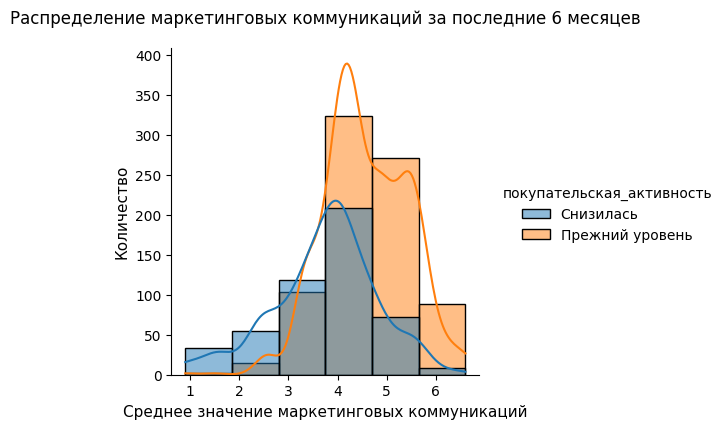

In [47]:
sns.displot(data=market_file, x='маркет_актив_6_мес', hue='покупательская_активность', kde=True, bins=6, height=4, aspect=1);
# Подписи осей
plt.xlabel('Среднее значение маркетинговых коммуникаций', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение маркетинговых коммуникаций за последние 6 месяцев', y=1.05);

- **В среднем у покупателей со сниженной покупательской активностью меньшее значение маркетинговых коммуникаций, чем у покупателей с прежней поупательской активностью.**

**Вычислим статистические характеристики для колонки с маркетинговыми коммуникациями за последние 6 месяцев.**

**Напишем функцию, определяющую границы усов для boxplot, чтобы охарактеризовать наши данные.**

In [48]:
def whisker_border(data=None, column=None):
    """
    Функция возвращает границы усов
    На вход принимает датафрейм и наименование столбца в виде строки. 
    Пример вызова: whisker_border(market_file,'маркет_актив_6_мес')
    """
   # df = pd.DataFrame(data[column].describe().round(2))
    df = pd.DataFrame(data[column].describe())

    #  75-й и 25-й процентили
    q75, q25 = df.loc['75%', column], df.loc['25%', column]
    # вычисляем интерквартильный размах iqr
    iqr = q75 - q25
    # нижняя граница усов
    low = q25 - 1.5 * iqr
    # если минимальная цена в выборке не выходит за границы усов,
    # то нижнюю границу задаем равной минимальной цене, как на графике boxplot
    if low < 0 or low < df.loc['min', column]:
        low = df.loc['min', column]
    # верхняя граница усов
    up = q75 + 1.5 * iqr
    # верхняя граница усов не превышает максимального значения выборки
    if up > df.loc['max', column]:
        up = df.loc['max', column]

    return (low, up)
    #return (round(low,3), round(up,3))

**Напишем функцию, которая будет выводить статистические характеристики, нижнюю и верхнюю границы усов, точки за них выходящие, датафрейм со статистическими характеристиками.**

In [49]:
def whiskers_points_behind(data=None, column=None):
    """
    Функция  выводит статистические характеристики,  нижнюю и верхнюю границы усов, 
    точки за них выходящие, датафрейм со статистическими характеристиками.
    На вход принимает датафрейм и наименование столбца в виде строки. 
    Пример вызова: whiskers_points_behind(market_file,'маркет_актив_6_мес')
    """
    print('-------------------------------------------------------------------------------')
    print(f'Статистические характеристики столбца {pd.DataFrame(data[column]).columns[0]}:')
    # вызов функции whisker_border()
    whiskers = whisker_border(data, column)
    print(f'Диапазон между нижней и верхней границей усов - {whiskers}.')
    
    # количество точек правее верхней границы
    count1 = len(data[data[column] > whiskers[1]])
    print(f'Количество точек правее верхней границы усов - {count1} ({round(100*count1/data.shape[0], 2)}%).')
    # количество точек левее нижней границы
    count2 = len(data[data[column] < whiskers[0]])
    print(f'Количество точек левее нижней границы усов - {count2} ({round(100*count2/data.shape[0], 2)}%).')
    # количество точек между нижней и верхней границей
    count3 = len(data[data[column].notna()]) - count1 - count2
    print(f'Количество точек между нижней и верхней границей усов - {count3} ({round(100*count3/data.shape[0], 2)}%).')
    print('-------------------------------------------------------------------------------')
    return pd.DataFrame(data[column].describe()) # возвращает датафрейм со стат.характеристиками

**Напишем функцию, которая выводит статистические характеристики для заданного признака в разрезе классов "Снизилась" и "Прежний уровень".**

In [50]:
def compare_func(data=None, column=None):
    """
    Функция  выводит статистические характеристики,  нижнюю и верхнюю границы усов, 
    точки за них выходящие, датафрейм со статистическими характеристиками
    для заданного признака (столбца column) в разрезе классов Снизилась и 
    Прежний уровень.
    На вход принимает датафрейм и наименование столбца в виде строки. 
    Пример вызова: whiskers_points_behind(market_file,'маркет_актив_6_мес')
    """
    print('Класс Снизилась')
    df1 = whiskers_points_behind(
        data[data['покупательская_активность']=='Снизилась'],column).rename(columns={column:'Снизилась'})
    print('Класс Прежний уровень')
    df2 = whiskers_points_behind(
        data[data['покупательская_активность']=='Прежний уровень'],column).rename(columns={column:'Прежний уровень'})
    
    return df1.join(df2)

**Представим визульно основные статистические характеристики распределения маркетинговых коммуникаций за последние 6 месяцев.**

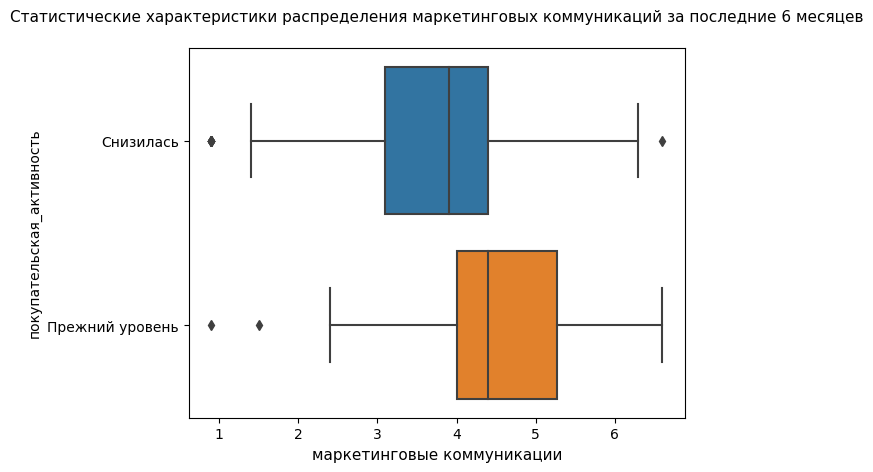

In [51]:
sns.boxplot(x='маркет_актив_6_мес', y='покупательская_активность', data=market_file, showfliers=True); # ящик с усами
# заголовок
plt.title(
    'Статистические характеристики распределения маркетинговых коммуникаций за последние 6 месяцев', 
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('маркетинговые коммуникации', fontsize=11);

* В классе Снизилась более широкий диапазон значений маркетинговых коммуникаций.
* В классе Прежний уровень более сжатое распределение маркетинговых коммуникаций.
* В классе Прежний уровень более высокое медианное значение маркетинговых коммуникаций.

In [52]:
compare_func(market_file, 'маркет_актив_6_мес')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца маркет_актив_6_мес:
Диапазон между нижней и верхней границей усов - (1.1499999999999997, 6.3500000000000005).
Количество точек правее верхней границы усов - 1 (0.2%).
Количество точек левее нижней границы усов - 10 (2.02%).
Количество точек между нижней и верхней границей усов - 483 (97.77%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца маркет_актив_6_мес:
Диапазон между нижней и верхней границей усов - (2.0874999999999995, 6.6).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 2 (0.25%).
Количество точек между нижней и верхней границей усов - 800 (99.75%).
--------------------------------------------------------------------------

,Снизилась,Прежний уровень
count,494.000000,802.000000
mean,3.747166,4.570075
std,1.052777,0.848618
min,0.900000,0.900000
25%,3.100000,4.000000
50%,3.900000,4.400000
75%,4.400000,5.275000
max,6.600000,6.600000


**Исследование маркетинговых коммуникаций за последние 6 месяцев в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение маркетинговых коммуникаций в классе "Снизилась" - 3.9 меньше, чем в классе "Прежний уровень" (4.4).
- 25% покупателей с наименьшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 1.1 до 3.1, в классе "Прежний уровень" - от 2.1 до 4.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее число маркетинговых коммуникаций - от 3.1 до 4.4, в классе "Прежний уровень" - от 4 до 5.3.
- 25% покупателей с наибольшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 4.4 до 6.35, в классе "Прежний уровень" - от 5.3 до 6.6.           
**В классе "Снизилась" более широкий диапазон значений маркетинговых коммуникаций. В классе "Прежний уровень" более сжатое распределение маркетинговых коммуникаций.**   

### Исследование количества дней с момента регистрации покупателя на сайте

**Представим распределение количества дней с момента регистрации покупателя на сайте в виде гистограммы.**

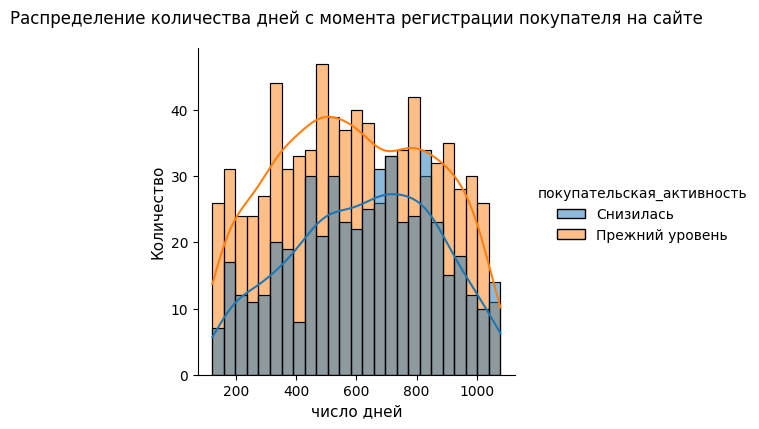

In [53]:
sns.displot(data=market_file, x='длительность', hue='покупательская_активность', kde=True, bins=25, height=4, aspect=1);
# Подписи осей
plt.xlabel('число дней', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение количества дней с момента регистрации покупателя на сайте', y=1.05);

**Представим визульно основные статистические характеристики распределения количества дней с момента регистрации покупателя на сайте.**

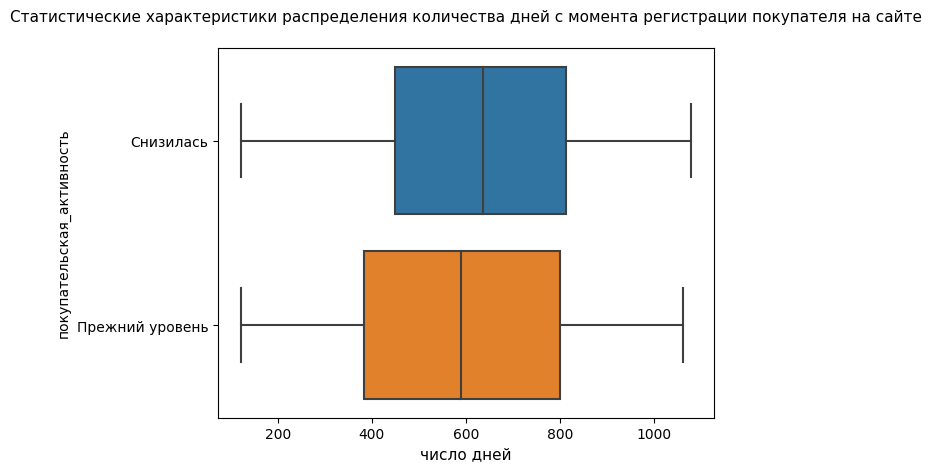

In [54]:
sns.boxplot(x='длительность', data=market_file, y='покупательская_активность', showfliers=True); # ящик с усами
# заголовок
plt.title(
    'Статистические характеристики распределения количества дней с момента регистрации покупателя на сайте',\
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('число дней', fontsize=11);

**Таким образом, в среднем в классе "Снизилась" более давние клиенты по сравнению с классом "Прежний уровень".**

**Вычислим статистические характеристики распределения количества дней с момента регистрации покупателя на сайте.**

In [55]:
compare_func(market_file, 'длительность')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца длительность:
Диапазон между нижней и верхней границей усов - (121.0, 1079.0).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 494 (100.0%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца длительность:
Диапазон между нижней и верхней границей усов - (121.0, 1061.0).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 802 (100.0%).
-------------------------------------------------------------------------------


,Снизилась,Прежний уровень
count,494.000000,802.000000
mean,622.834008,590.730673
std,237.817052,255.330179
min,121.000000,121.000000
25%,449.000000,382.500000
50%,636.500000,590.000000
75%,812.500000,798.750000
max,1079.000000,1061.000000


**Исследование количества дней с момента регистрации покупателя на сайте в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества дней с момента регистрации покупателя на сайте в классе "Снизилась" - 637 больше, чем в классе "Прежний уровень" (590).
- 25% покупателей с наименьшим количеством дней с момента регистрации в классе "Снизилась" - от 121 до 449, в классе "Прежний уровень" - от 121 до 383.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют количество дней с момента регистрации - от 449 до 813, в классе "Прежний уровень" - от 383 до 799.
- 25% покупателей с наибольшим количеством дней с момента регистрации  в классе "Снизилась" - от 813 до 1079, в классе "Прежний уровень" - от 799 до 1061.         

### Исследование cреднемесячной доли акционных покупок за последние 6 месяцев

**Представим распределение cреднемесячной доли акционных покупок за последние 6 месяцев в виде гистограммы.**

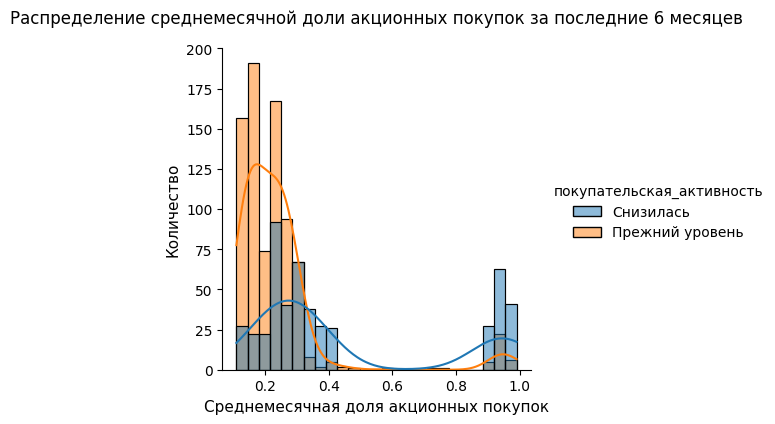

In [56]:
sns.displot(data=market_file, x='акционные_покупки', kde=True, hue='покупательская_активность',\
            bins=25, height=4, aspect=1);
# Подписи осей
plt.xlabel('Среднемесячная доля акционных покупок', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение cреднемесячной доли акционных покупок за последние 6 месяцев', y=1.05);

**На гистограмме видны 2 сегмента: с высокой и низкой долей акционных покупок. При этом в каждом сегменте есть представители 2 классов: Снизилась и Прежний уровень.**   
**Снижение покупательской активности сильно затронуло сегмент с высокой долей акционных покупок, если рассматривать в относительных величинах. Однако, если рассматривать в абсолютных величинах, то сегмент с низкой долей акционных покупок имеет более высокое снижение покупательской активности.** 

**Разобъем условно данные на 2 сегмента: сегмент с низкой долей покупок по акции - до 0.5, сегмент с высокой долей покупок по акции - от 0.5 до до 1.**

In [57]:
# создаем категориальный столбец для сегментов с низкой и высокой долей акционных покупок
market_file['акционные_покупки_категории'] = pd.cut(
    market_file['акционные_покупки'], [-float('inf'), 0.5, 1], \
    labels=["низкая доля акционных покупок", "высокая доля акционных покупок"])

In [58]:
# относительное значение покупателей в сегментах
display(market_file['акционные_покупки_категории'].value_counts(normalize=True))
# абсолютное значение покупателей в сегментах
market_file['акционные_покупки_категории'].value_counts()

низкая доля акционных покупок     0.871142
высокая доля акционных покупок    0.128858
Name: акционные_покупки_категории, dtype: float64

низкая доля акционных покупок     1129
высокая доля акционных покупок     167
Name: акционные_покупки_категории, dtype: int64

В числовых величинах:
* Сегмент с низкой долей покупок по акции: 1129 покупателей, 87%.
* Сегмент с высокой долей покупок по акции: 167 покупателей, 13%.        

In [59]:
df = market_file.reset_index().pivot_table(
    index='акционные_покупки_категории', columns='покупательская_активность', values = 'id', aggfunc='count')   
df['Прежний уровень доля'] = (df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Снизилась доля'] = 1 - df['Прежний уровень доля'] 
df

покупательская_активность,Прежний уровень,Снизилась,Прежний уровень доля,Снизилась доля
акционные_покупки_категории,,,,
низкая доля акционных покупок,768,361,0.68,0.32
высокая доля акционных покупок,34,133,0.20,0.80


**Исследование покупательской активности в зависимости от деления на сегменты по доли акционных покупок:**  

* В сегменте с высокой долей акционных покупок: покупательская активность снизилась в 80% случаев (133 покупателя), осталась на прежнем уровне - в 20% случаев (34 покупателя).     
* В сегменте с низкой долей акционных покупок: покупательская активность снизилась в 32% случаев (361 покупатель), осталась на прежнем уровне - в 68% случаев (768 покупателей). 

**Посмотрим на ящик с усами без разбиения на сегменты и с разбиением отдельно.**

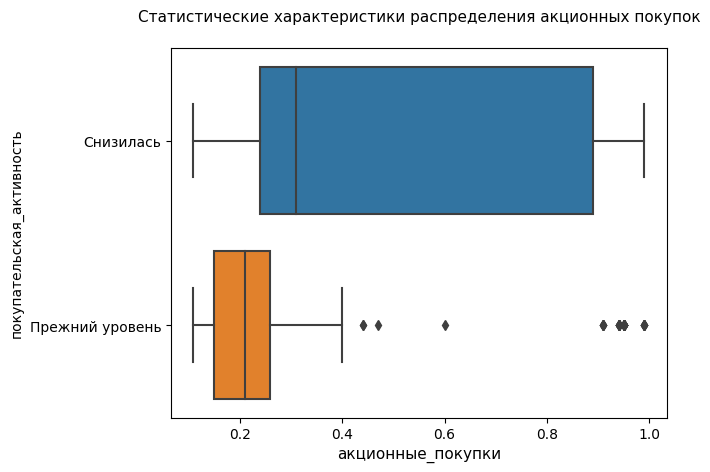

In [60]:
sns.boxplot(x='акционные_покупки', y='покупательская_активность', data=market_file, showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения акционных покупок', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('акционные_покупки', fontsize=11);

**Класс покупательская активность "Снизилась" имеет более широкое распределение акционных покупок по сравнению с классом покупательской активности "Прежний уровень".**

In [61]:
compare_func(market_file, 'акционные_покупки')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.99).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 494 (100.0%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.42500000000000004).
Количество точек правее верхней границы усов - 37 (4.61%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 765 (95.39%).
-------------------------------------------------------------------------------


,Снизилась,Прежний уровень
count,494.000000,802.000000
mean,0.452713,0.238367
std,0.304428,0.160599
min,0.110000,0.110000
25%,0.240000,0.150000
50%,0.310000,0.210000
75%,0.890000,0.260000
max,0.990000,0.990000


**Исследование акционных покупок без разбиения на сегменты по доле акционных покупок:**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.31 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.24, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.24 до 0.89, в классе "Прежний уровень" - от 0.15 до 0.26.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.89 до 0.99, в классе "Прежний уровень" - от 0.26 до 0.43.
В классе "Снизилась" более широкий диапазон значений доли акционных покупок. В классе "Прежний уровень" более сжатое распределение доли акционных покупок.   

**Теперь посмотрим на ящик с усами с разбиением на сегменты по доле акционных покупок.**

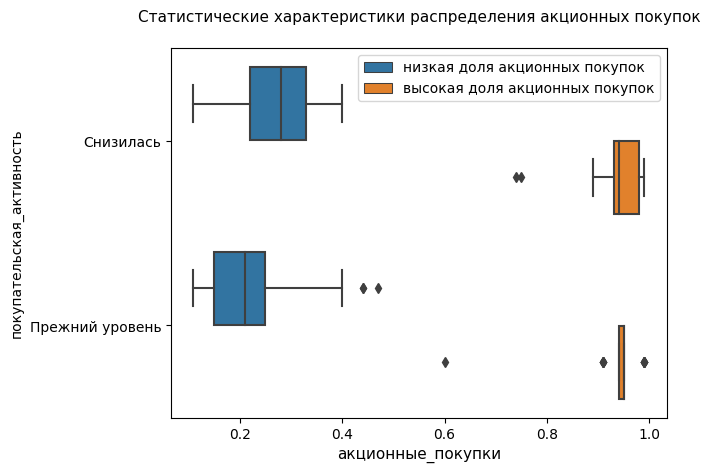

In [62]:
sns.boxplot(x='акционные_покупки', y='покупательская_активность', \
            hue='акционные_покупки_категории', data=market_file, showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения акционных покупок', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('акционные_покупки', fontsize=11);
plt.legend(loc='best');

**Исследование акционных покупок с разбиением на сегменты по доле акционных покупок:** 
* Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое распределение, при этом медианное значение примерно на одном уровне.
* Для сегмента с низкой долей акционных покупок для класса "Прежний уровень" меньшее медианное значение по сравнению с классом "Снизилась".
* Этот график демонстрирует, что есть часть клиентов с высокой долей акционных покупок, но при этом их покупательская активность не снижается.    
Ниже опишем подробно с числовыми характеристиками.

**Вычислим статистические характеристики распределения акционных покупок для сегмента с низкой долей акционных покупок.**

In [63]:
market_file['акционные_покупки_категории'].value_counts()

низкая доля акционных покупок     1129
высокая доля акционных покупок     167
Name: акционные_покупки_категории, dtype: int64

In [64]:
compare_func(market_file[market_file['акционные_покупки_категории']=='низкая доля акционных покупок'], 'акционные_покупки')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.4).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 361 (100.0%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.11, 0.4).
Количество точек правее верхней границы усов - 3 (0.39%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 765 (99.61%).
-------------------------------------------------------------------------------


,Снизилась,Прежний уровень
count,361.000000,768.000000
mean,0.272742,0.207370
std,0.075214,0.063752
min,0.110000,0.110000
25%,0.220000,0.150000
50%,0.280000,0.210000
75%,0.330000,0.250000
max,0.400000,0.470000


**Исследование акционных покупок для сегмента с низкой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1129 экземпляров данных: 361 экземпляр данных - в классе "Снизилась", 768 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.28 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.22, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.22 до 0.33, в классе "Прежний уровень" - от 0.15 до 0.25.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.33 до 0.4, в классе "Прежний уровень" - от 0.25 до 0.4.         
**В классе "Снизилась" более высокое медианное значение доли акционных покупок (0.28), чем в классе "Прежний уровень" (0.21)**.   

**Вычислим статистические характеристики распределения акционных покупок для сегмента с высокой долей акционных покупок.**

In [65]:
compare_func(market_file[market_file['акционные_покупки_категории']=='высокая доля акционных покупок'], 'акционные_покупки')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.8550000000000002, 0.99).
Количество точек правее верхней границы усов - 0 (0.0%).
Количество точек левее нижней границы усов - 2 (1.5%).
Количество точек между нижней и верхней границей усов - 131 (98.5%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца акционные_покупки:
Диапазон между нижней и верхней границей усов - (0.9249999999999999, 0.965).
Количество точек правее верхней границы усов - 6 (17.65%).
Количество точек левее нижней границы усов - 6 (17.65%).
Количество точек между нижней и верхней границей усов - 22 (64.71%).
-------------------------------------------------------------------------------


,Снизилась,Прежний уровень
count,133.000000,34.000000
mean,0.941203,0.938529
std,0.041158,0.064297
min,0.740000,0.600000
25%,0.930000,0.940000
50%,0.940000,0.950000
75%,0.980000,0.950000
max,0.990000,0.990000


**Исследование акционных покупок для сегмента с высокой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 167 экземпляров данных: 133 экземпляра данных - в классе "Снизилась", 34 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.94 меньше, чем в классе "Прежний уровень" (0.95).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.86 до 0.93, в классе "Прежний уровень" - от 0.92 до 0.94.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.93 до 0.98, в классе "Прежний уровень" - от 0.94 до 0.95.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.98 до 0.99, в классе "Прежний уровень" - от 0.95 до 0.97.   
**Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое рапределение.**

### Исследование среднего количества просмотренных страниц за визит

**Представим распределение среднего количества просмотренных страниц за визит в виде гистограммы.**

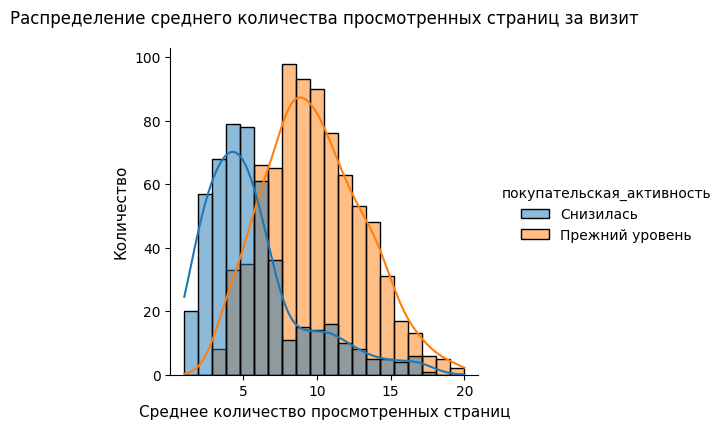

In [66]:
sns.displot(data=market_file, x='страниц_за_визит', hue='покупательская_активность', kde=True, bins=20, height=4, aspect=1);
# Подписи осей
plt.xlabel('Среднее количество просмотренных страниц', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение среднего количества просмотренных страниц за визит', y=1.05);

- **Распределение среднего количества просмотренных страниц для класса "Снизилась" находится левее, чем класса "Прежний уровень". Это говорит о том, что большая часть клиентов в сегменте "Снизилась" имеет меньшее количество просмотренных страниц по сравнению с сегментом "Прежний уровень".**   
- **Распределение среднего количества просмотренных страниц для класса "Снизилась" имеет широкий правый хвост, что говорит о том, что часть клиентов этого сегмента просматривает достаточно большое количество просмотренных страниц, однако их активность все равно снизилась.**

**Представим визульно основные статистические характеристики распределения среднего количества просмотренных страниц за визит.**

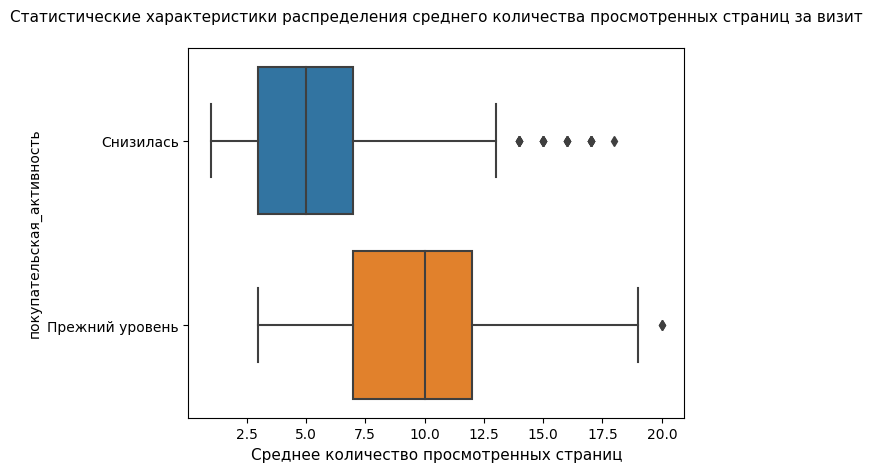

In [67]:
sns.boxplot(x='страниц_за_визит', data=market_file, y='покупательская_активность', showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения среднего количества просмотренных страниц за визит', \
          y=1.05, fontsize=11);
# подпись оси
plt.xlabel('Среднее количество просмотренных страниц', fontsize=11);

**Вычислим статистические характеристики распределения среднего количества просмотренных страниц за визит.**

In [68]:
compare_func(market_file, 'страниц_за_визит')

Класс Снизилась
-------------------------------------------------------------------------------
Статистические характеристики столбца страниц_за_визит:
Диапазон между нижней и верхней границей усов - (1.0, 13.0).
Количество точек правее верхней границы усов - 21 (4.25%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 473 (95.75%).
-------------------------------------------------------------------------------
Класс Прежний уровень
-------------------------------------------------------------------------------
Статистические характеристики столбца страниц_за_визит:
Диапазон между нижней и верхней границей усов - (3.0, 19.5).
Количество точек правее верхней границы усов - 2 (0.25%).
Количество точек левее нижней границы усов - 0 (0.0%).
Количество точек между нижней и верхней границей усов - 800 (99.75%).
-------------------------------------------------------------------------------


,Снизилась,Прежний уровень
count,494.000000,802.000000
mean,5.574899,9.796758
std,3.463729,3.376846
min,1.000000,3.000000
25%,3.000000,7.000000
50%,5.000000,10.000000
75%,7.000000,12.000000
max,18.000000,20.000000


**Исследование среднего количества просмотренных страниц за визит в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества просмотренных страниц за визит в классе "Снизилась" - 5, что значительно меньше, чем в классе "Прежний уровень" (10).
- 25% покупателей с наименьшим средним количеством просмотренных страниц за визит в классе "Снизилась" - от 1 до 3, в классе "Прежний уровень" - от 3 до 7.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее количество просмотренных страниц за визит - от 0.3 до 7, в классе "Прежний уровень" - от 7 до 12.
- 25% покупателей с наибольшим количеством просмотренных страниц за визит в классе "Снизилась" - от 7 до 13, в классе "Прежний уровень" - от 12 до 19.    
Таким образом, в среднем покупатели класса "Снизилась" имеют меньшее количество просмотренных страниц за визит, чем класса "Прежний уровень".

### Исследование маркетинговых коммуникаций в текущем месяце

**Исследуем количество маркетинговых коммуникаций в текущем месяце, которое приходилось на покупателя. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.**

In [69]:
market_file['маркет_актив_тек_мес'].nunique() # количество уникальных значений

3

In [70]:
market_file['маркет_актив_тек_мес'].sort_values().unique() # уникальные значения

array([3, 4, 5], dtype=int64)

**Данные по маркетинговым коммуникациям дискретны, поэтому будем использовать столбиковую диаграмму.**

**Создадим функцию для построения столбиковой диаграммы с уже готовым оформлением графика. Регулировать можно заголовок, подписи осей, метки над столбиком, если нужны, размер графика, поворот надписей под углом по оси абсцисс.**

In [71]:
"""
Функция создает столбиковую диаграмму. На вход функции поступает датафрейм data, 
столбец для построения column, заголовок графика title, подпись по оси абсцисс xlabel,
подпись по оси ординат ylabel, размер графика figsize, подпись величины столбика label - 
абсолютная - 1, абсолютная и относительная - 2, без подписи - 0,
порядок сортировки order_sort - без сортировки (0), по убыванию (1), по возрастанию (2),
поворот подписи по оси абсцисс rotation, палитра palette (по умолчанию 'Paired'). 
Подпись величины столбика label может принимать 3 значения: 0, 1, 2:
0- без подписи, столбики не упорядочены. 
1 - абсолютное значение столбика, 2 - относительное значение столбика. 

Пример вызова функции:
countplot_label(data=market_file, column='маркет_актив_тек_мес', \
                title='Маркетинговые коммуникации в текущем месяце', \
                xlabel='Маркетинговые коммуникации', ylabel='Количество', \
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')
"""
def countplot_label(data=None, column=None, title=None, xlabel=None, \
                    ylabel=None, figsize=(6,4), label=0, order_sort=0, \
                    rotation=0, palette='Paired'):
    # задаем размер и четкость-количество точек на дюйм
    plt.figure(figsize=figsize,dpi=100)
    sns.set(style='whitegrid') # добавим сетку (белый фон серая сетка) на заднем фоне
    #по умолчанию style='white'

    # Создадим датафрейм df, содержащий 3 столбца - абсолютные, относительные значения 
    # категории, третий столбец - кортеж из абс. и относ. значений (отформатированный по стилю)
    # абсолютные значения по категории
    abs_values = data[column].value_counts(ascending=False)
    # относительные значения по категории
    rel_values = data[column].value_counts(ascending=False, normalize=True).round(3).values *100
    # создание датафрейма
    df = pd.DataFrame(abs_values)
    df['relative'] = rel_values
    # наименования столбцов
    df.columns = ['absolute', 'relative'] 
    # список из кортежей абсолютных и относительных значений
    lst=list(zip(df['absolute'], df['relative']))
    # создание столбца из абс. и отн. значений, отформатированных (для отн. значений -
    # после запятой 1 знак и процент)
    df['total']=[f'{p[0]} ({p[1]:.1f}%)' for p in lst]
    # сортировка по индексу
    df = df.sort_index()
    
    #порядок действий в зависимости от заданных значений
    if order_sort == 2: # по возрастанию
        df = df.sort_values(by='absolute')
        order = df.index
        if label == 1: # 1 метка - абсолютная
            lbls = df['absolute'].values
        elif label == 2: # 2 метки абс. и отн.
            lbls = df['total'].values
        elif label == 0:
            lbls=''
    elif order_sort == 1: # по убыванию
        df = df.sort_values(by='absolute', ascending=False)
        order = df.index
        if label == 1: # 1 метка - абсолютная
            lbls = df['absolute'].values
        elif label == 2: # 2 метки
            lbls = df['total'].values
        elif label == 0:
            lbls=''
    elif order_sort == 0: # без сортировки
        order = df.index
        if label == 1: # 1 метка - абсолютная
            lbls = df['absolute'].values
        elif label == 2: # 2 метки абс. и отн.
            lbls = df['total'].values
        elif label == 0:
            lbls=''
    # построение графика
    ax = sns.countplot(data=data, x=column, order=order, palette='Paired');
    # метки над графиком
    for p, label in zip(ax.patches, lbls):
            ax.annotate(label, (p.get_x(), p.get_height()))
    # названия осей
    plt.xlabel(xlabel, fontsize=11);
    plt.xticks(rotation=rotation) # поворот надписи по оси абсцисс
    plt.ylabel(ylabel, fontsize=11);
    # заголовок
    plt.title(title, y=1.05, fontsize=11);
    # чтобы оси не пересекались с соседними графиками
    plt.tight_layout();

**Построим графики в разрезе классов "Снизилась" и "Прежний уровень".**

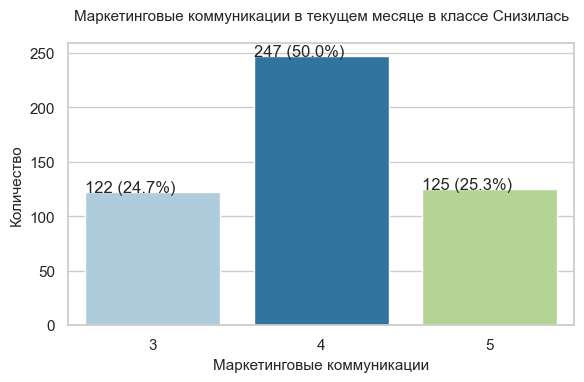

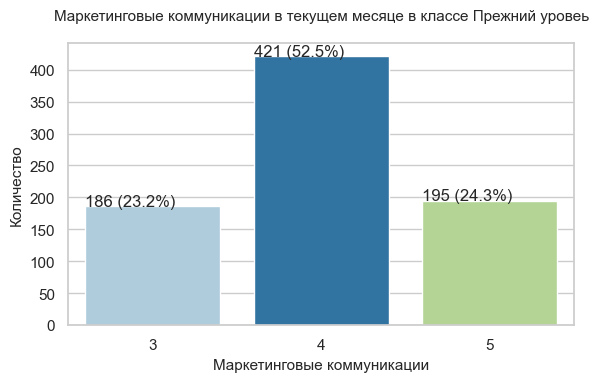

In [72]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'], column='маркет_актив_тек_мес', \
                title='Маркетинговые коммуникации в текущем месяце в классе Снизилась', \
                xlabel='Маркетинговые коммуникации', ylabel='Количество', \
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], column='маркет_актив_тек_мес', \
                title='Маркетинговые коммуникации в текущем месяце в классе Прежний уровеь', \
                xlabel='Маркетинговые коммуникации', ylabel='Количество', \
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование количества маркетинговых коммуникаций в текущем месяце  в разрезе классов "Снизилась" и "Прежний уровень":**       
В относительных величинах количество маркетинговых коммуникаций в разрезе классов "Снизилась" и "Прежний уровень" примерно одинаково. Однако в абсолютных величинах ввиду того, что класс "Прежний уровень" имеет значительно большее количество покупателей по сравнению с классом "Снизилась" - значения класса "Прежний уровень" значительно больше.    

### Исследование среднего количества просмотров категорий за визит в течение последнего месяца

**Исследуем, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.**

In [73]:
market_file['средний_просмотр_категорий_за_визит'].nunique() # количество уникальных значений

6

In [74]:
market_file['средний_просмотр_категорий_за_визит'].sort_values().unique() # уникальные значения

array([1, 2, 3, 4, 5, 6], dtype=int64)

**Данные по среднему количеству просмотров категорий за визит в течение последнего месяца дискретны, поэтому будем использовать столбиковую диаграмму.**

**Построим графики в разрезе классов "Снизилась" и "Прежний уровень".**

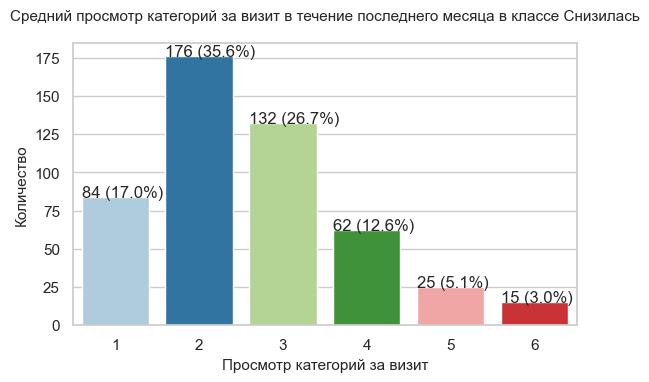

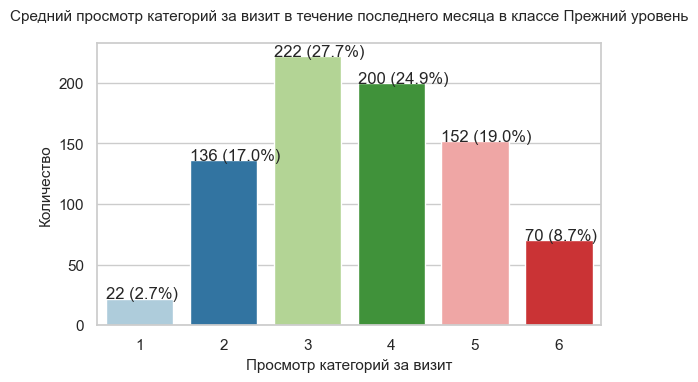

In [75]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'], 
                column='средний_просмотр_категорий_за_визит', 
                title='Средний просмотр категорий за визит в течение последнего месяца в классе Снизилась', 
                xlabel='Просмотр категорий за визит', ylabel='Количество', 
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], 
                column='средний_просмотр_категорий_за_визит', 
                title='Средний просмотр категорий за визит в течение последнего месяца в классе Прежний уровень', 
                xlabel='Просмотр категорий за визит', ylabel='Количество', 
                figsize=(6,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование среднего количества просмотров категорий за визит в течение последнего месяца  в разрезе классов "Снизилась" и "Прежний уровень":**       
* В относительных величинах в  среднем среднее количество просмотров категорий за визит в классе  "Прежний уровень" выше, чем в классе "Снизилась". 
* В классе Снизилась первые 3 категории с наибольшим количеством просмотров - 2 (176 чел., 35.6%), 3 (132 чел., 26.7%), 1 (84 чел., 17%), а в классе  "Прежний уровень" - 3 (222 чел., 27.7%), 4 (200 чел., 24.9%), 5 (152 чел., 19%).

### Исследование общего числа неоплаченных товаров за последние 3 месяца

Исследуем общее число неоплаченных товаров в корзине за последние 3 месяца.

In [76]:
market_file['неоплаченные_продукты_штук_квартал'].nunique() # количество уникальных значений

11

In [77]:
market_file['неоплаченные_продукты_штук_квартал'].sort_values().unique() # уникальные значения

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

**Данные по общему числу неоплаченных товаров за последние 3 месяца дискретны, поэтому будем использовать столбиковую диаграмму.**

**Построим графики в разрезе классов "Снизилась" и "Прежний уровень".**

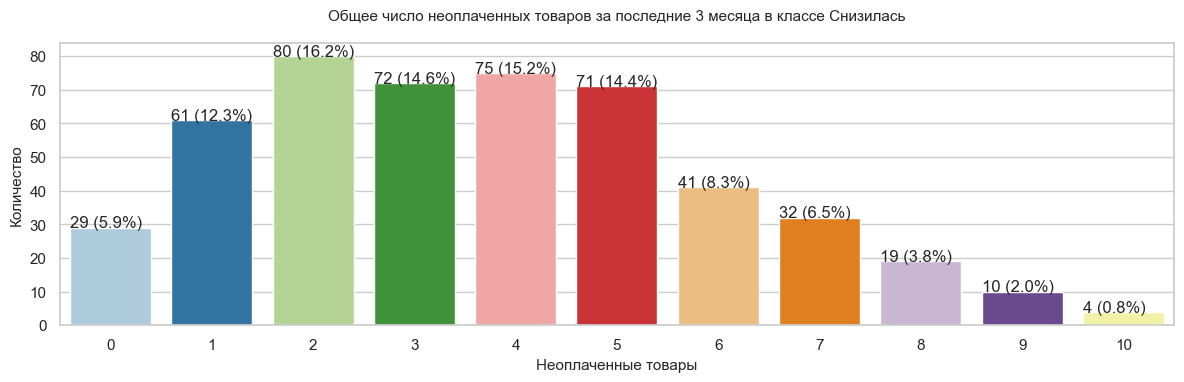

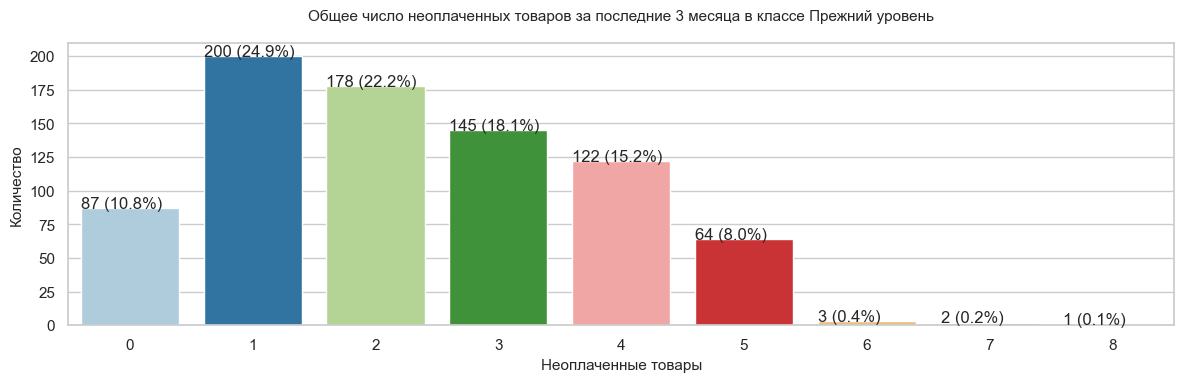

In [78]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'],
                column='неоплаченные_продукты_штук_квартал', 
                title='Общее число неоплаченных товаров за последние 3 месяца в классе Снизилась', 
                xlabel='Неоплаченные товары', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], 
                column='неоплаченные_продукты_штук_квартал', 
                title='Общее число неоплаченных товаров за последние 3 месяца в классе Прежний уровень', 
                xlabel='Неоплаченные товары', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование общего числа неоплаченных товаров за последние 3 месяца в разрезе классов "Снизилась" и "Прежний уровень":**
* В классах "Снизилась" и "Прежний уровень" распределение неоплаченных товаров отличается.        
* Класс "Снизилась" более активно использует корзину для хранения интересующих товаров.
* В классе "Снизилась" примерно равномерное распределение на участке от 2 до 5 товаров в корзине: 2 товара - 80 чел., 15.6%, 3 товара - 72 чел., 14.6%, 4 товара - 75 чел., 15.2%, 5 товаров - 71 чел., 14.4%.
* Для класса "Прежний уровень" количество товаров в корзине с 1 до 8 идет на убывание: 1 товар - 200 чел., 24.9%, 2 товара - 178 чел., 22.2%, 3 товара - 145 чел., 18.1%, 4 товара - 122 чел., 15.2%, 5 товаров - 64 чел., 8%.
* Для каждого из классов есть покупатели, не имеющие неоплаченные товары в корзине: класс "Снизилась" - 29 чел., 5.9%, класс "Прежний уровень" - 87 чел., 10%.

### Исследование количества сбоев во время посещения сайта

Исследуем ошибки сервиса, то есть число сбоев, которые коснулись покупателя во время посещения сайта.

In [79]:
market_file['ошибка_сервиса'].nunique() # количество уникальных значений

10

In [80]:
market_file['ошибка_сервиса'].sort_values().unique() # уникальные значения

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

**Данные по числу сбоев во время посещения сайта дискретны, поэтому будем использовать столбиковую диаграмму.**

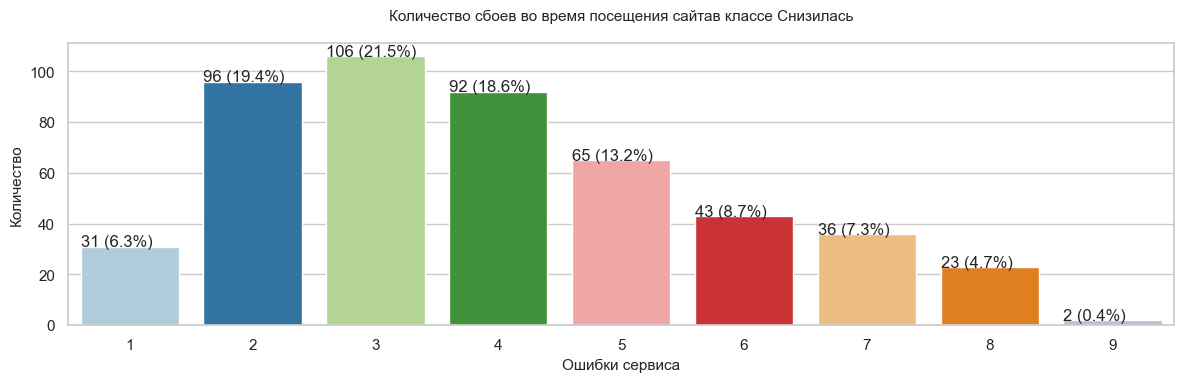

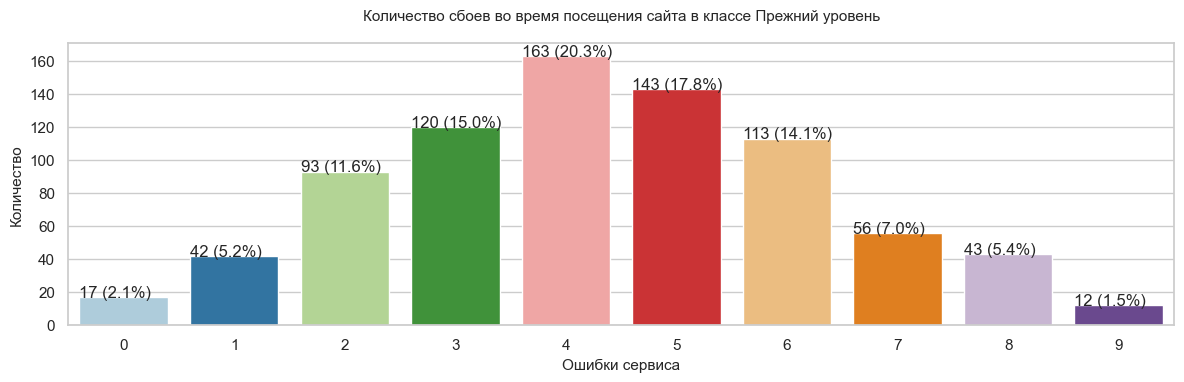

In [81]:
countplot_label(data=market_file[market_file['покупательская_активность']=='Снизилась'],
                column='ошибка_сервиса', 
                title='Количество сбоев во время посещения сайтав классе Снизилась',
                xlabel='Ошибки сервиса', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')
countplot_label(data=market_file[market_file['покупательская_активность']=='Прежний уровень'], 
                column='ошибка_сервиса', 
                title='Количество сбоев во время посещения сайта в классе Прежний уровень',  
                xlabel='Ошибки сервиса', ylabel='Количество', 
                figsize=(12,4), label=2, order_sort=0, rotation=0, palette='Paired')

**Вполне логично, что во время посещения сайта у класса Прежний уровень возникает большее количество ошибок сервиса, чем у класса Снизилась. Это связано с большим количеством просмотренных страниц и категорий за визит, как было выяснено ранее.**

### Исследование класса покупательской активности

Исследуем класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

**Покупательская активность - категориальный признак, построим для него столбиковую диаграмму.**

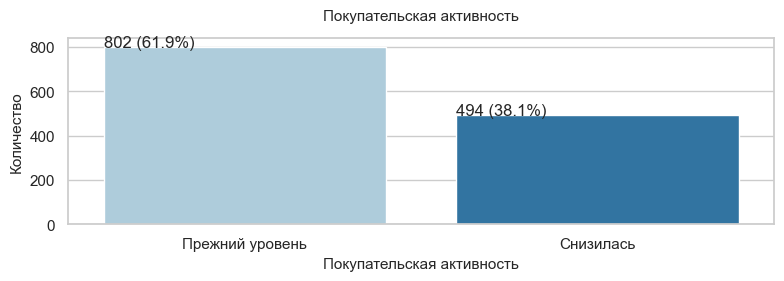

In [82]:
countplot_label(data=market_file, column='покупательская_активность', \
                title='Покупательская активность', \
                xlabel='Покупательская активность', ylabel='Количество', \
                figsize=(8,3), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование класса покупательской активности:**    
* Покупательская активность осталась на прежнем уровне у 802 покупателей (61.9%).    
* Покупательская активность снизилась у 494 покупателей (38.1%).      

**А теперь исследуем покупательскую активность в зависимости от различных категориальных признаков.**

#### Исследование типа сервиса и покупательской активности в зависимости от типа сервиса

Тип сервиса - категориальный признак, построим для него столбиковую диаграмму.

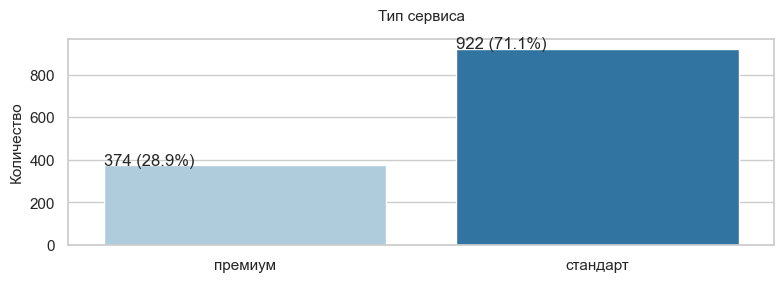

In [83]:
countplot_label(data=market_file, column='тип_сервиса', \
                title='Тип сервиса', \
                xlabel='', ylabel='Количество', \
                figsize=(8,3), label=2, order_sort=0, rotation=0, palette='Paired')

**Исследование типа сервиса:**    
* 922 покупателя (71.1%) относятся к сервису "стандарт".      
* 375 покупателей (28.9%) относятся к сервису "премиум".

**Исследуем покупательскую активность в зависимости от типа сервиса.**

покупательская_активность,Прежний уровень,Снизилась,Доля класса Прежний уровень,Доля класса Снизилась
тип_сервиса,,,,
премиум,206,168,0.55,0.45
стандарт,596,326,0.65,0.35


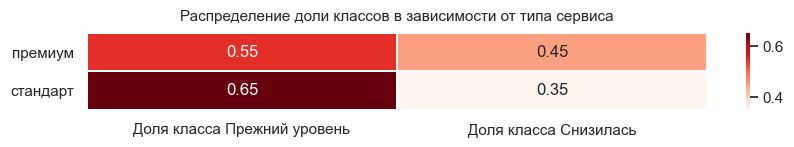

In [84]:
plt.figure(dpi=100, figsize=(10,1)) # размер, четкость
# группировка: в строках - тип сервиса, в столбцах - Класс, агрегирующая функция - количество
df = market_file.pivot_table(
    index='тип_сервиса', 
    columns = 'покупательская_активность', 
    aggfunc='count', 
    values='разрешить_сообщать')
df['Доля класса Прежний уровень'] = (
    df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])
).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от типа сервиса', y=1.05, fontsize=11);
# подписи на осях
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='', ylabel='');

**Исследование покупательской активности в зависимости от типа сервиса:**    
Для типа сервиса "премиум" 45% (168 покупателей) в классе "Снизилась", 55% (206 покупателей) в классе "Прежний уровень".         
Для типа сервиса "стандарт" 35% (326 покупателей) в классе "Снизилась", 65% (596 покупателей) в классе "Прежний уровень".

#### Исследование популярной категории и покупательской активности в зависимости от популярной категории.

**Популярная категория - категориальный признак, построим для него столбиковую диаграмму.**

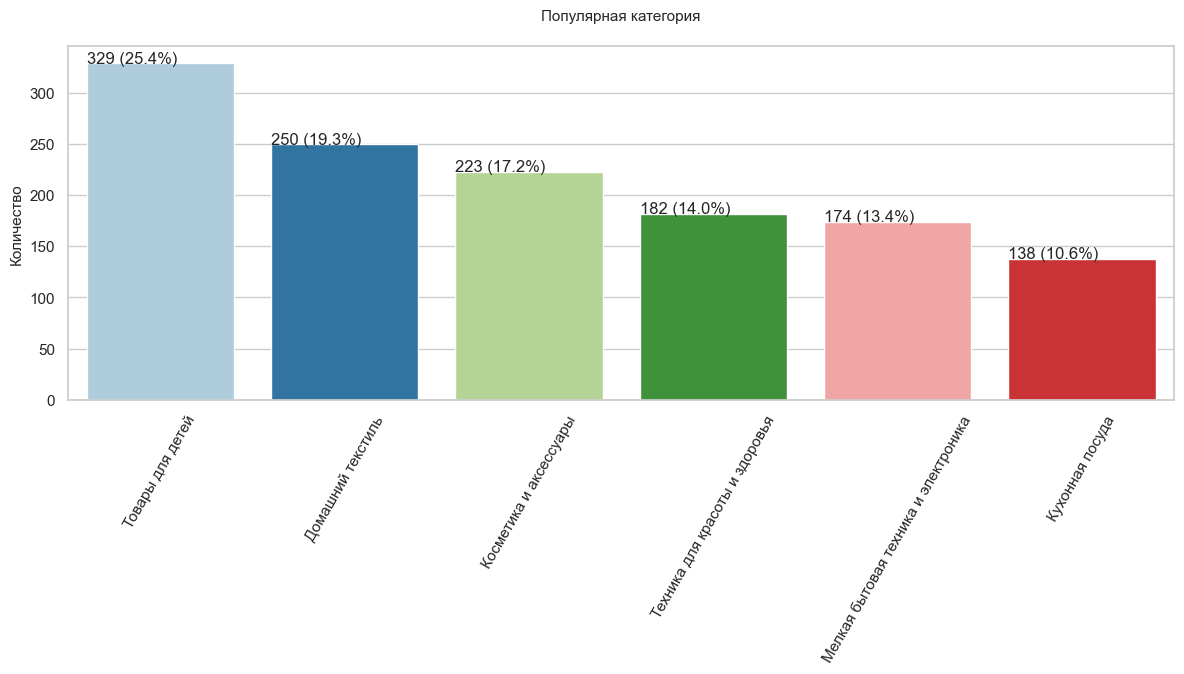

In [85]:
countplot_label(data=market_file, column='популярная_категория', \
                title='Популярная категория', \
                xlabel='', ylabel='Количество', \
                figsize=(12,7), label=2, order_sort=1, rotation=60, palette='Paired')

**Исследование популярной категории:**             
* Товары для детей - 329 покупателей (25.4%).
* Домашний текстиль - 250 покупателей (19.3%).
* Косметика и аксессуары - 223 покупателя (17.2%).
* Техника для красоты и здоровья - 182 покупателя (14%).
* Мелкая бытовая техника и электроника - 174 покупателя (13.4%).
* Кухонная посуда - 138 покупателей (10.6%).

**Исследуем покупательскую активность в зависимости от популярной категории.**

покупательская_активность,Прежний уровень,Снизилась,Доля класса Прежний уровень,Доля класса Снизилась
популярная_категория,,,,
Домашний текстиль,149,101,0.60,0.40
Косметика и аксессуары,118,105,0.53,0.47
Кухонная посуда,72,66,0.52,0.48
Мелкая бытовая техника и электроника,147,27,0.84,0.16
Техника для красоты и здоровья,132,50,0.73,0.27
Товары для детей,184,145,0.56,0.44


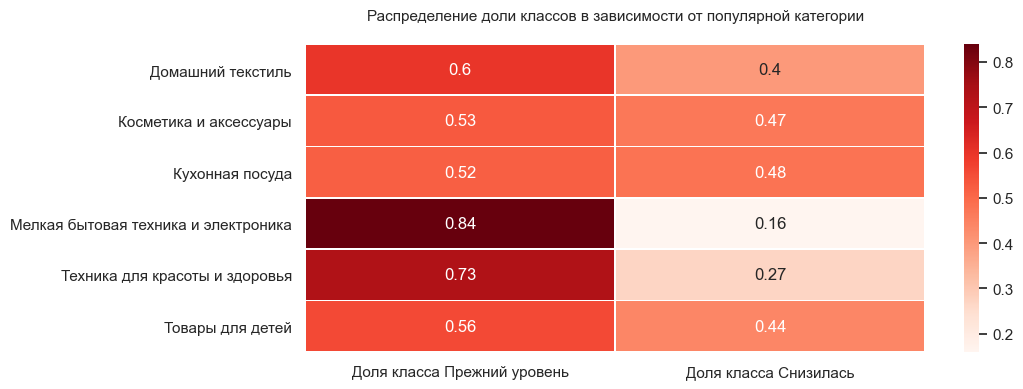

In [86]:
plt.figure(dpi=100, figsize=(10,4)) # размер, четкость
# группировка: по строкам - популярная_категория, по столбцам - покупательская активность, агрегирующая функция - количество.
df = market_file.pivot_table(
    index='популярная_категория', 
    columns = 'покупательская_активность', 
    aggfunc='count', 
    values='разрешить_сообщать')
df = df.fillna(0)
df['Доля класса Прежний уровень'] = (df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от популярной категории', y=1.05, fontsize=11);
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='', ylabel='');

**Исследование покупательской активности в зависимости от популярной категории:**    
  
*Наименьшее снижение в категориях:*
* "Мелкая бытовая техника и электроника" (16%, 27 покупателей).
* "Техника для красоты и здоровья" (27%, 50 покупатель).
   
*Наибольшее снижение в категориях:*
* "Кухонная посуда" (48%, 66 покупателей).
* "Косметика и аксессуары" (47%, 105 покупателей).
* "Товары для детей" (44%, 145 покупателей).
* "Домашний текстиль" (40%, 101 покупатель).

#### Исследование признака согласия по рассылке и покупательской активности в зависимости от этого признака

**Согласие по рассылке - категориальный признак, построим для него столбиковую диаграмму.**

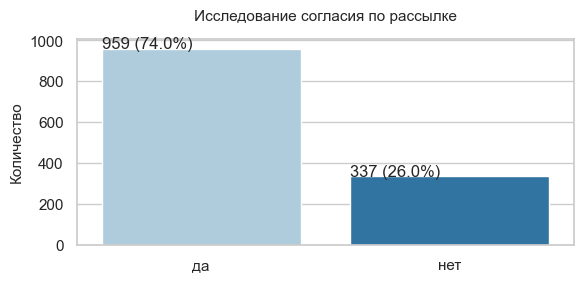

In [87]:
countplot_label(data=market_file, column='разрешить_сообщать', \
                title='Исследование согласия по рассылке', \
                xlabel='', ylabel='Количество', \
                figsize=(6,3), label=2, order_sort=1, rotation=0, palette='Paired')

**Исследование признака согласия по рассылке:**              
* Согласны - 959 покупателей (74%).       
* Не согласны - 337 покупателей (26%).

**Исследуем покупательскую активность в зависимости от согласия покупателя, можно ли присылать ему дополнительные предложения о товаре.**

покупательская_активность,Прежний уровень,Снизилась,Доля класса Прежний уровень,Доля класса Снизилась
разрешить_сообщать,,,,
да,591,368,0.62,0.38
нет,211,126,0.63,0.37


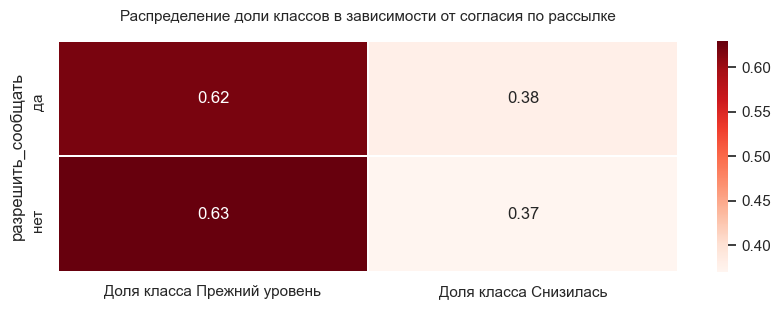

In [88]:
plt.figure(dpi=100, figsize=(10,3)) # размер, четкость
# группировка: по строкам - согласие покупателя, 
# по столбцам - покупательская активность, агрегирующая функция - количество.
df = market_file.pivot_table(
    index='разрешить_сообщать',
    columns = 'покупательская_активность',
    aggfunc='count',
    values='тип_сервиса')
df = df.fillna(0)
df['Доля класса Прежний уровень'] = (
    df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от согласия по рассылке', y=1.05, fontsize=11);
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='');

**Исследование покупательской активности в зависимости от согласия покупателя на дополнительную рассылку о предложениях по товарам:**    
* Произошло одинаковое снижение покупательской активности (38%) в относительных величинах в классах разрешить сообщать и не разрешать сообщение.   
* Покупательская активность снизилась у 38% покупателей (368 человек) среди давших разрешение на отправку предложений о товаре.    
* Покупательская активность снизилась у 37% покупателей (126 человек) среди недавших разрешение на отправку предложений о товаре.  

#### Исследование покупательской активности в зависимости от общего числа неоплаченных товаров в корзине за последние 3 месяца.

покупательская_активность,Прежний уровень,Снизилась,Доля класса Прежний уровень,Доля класса Снизилась
неоплаченные_продукты_штук_квартал,,,,
0,87.0,29.0,0.75,0.25
1,200.0,61.0,0.77,0.23
2,178.0,80.0,0.69,0.31
3,145.0,72.0,0.67,0.33
4,122.0,75.0,0.62,0.38
5,64.0,71.0,0.47,0.53
6,3.0,41.0,0.07,0.93
7,2.0,32.0,0.06,0.94
8,1.0,19.0,0.05,0.95


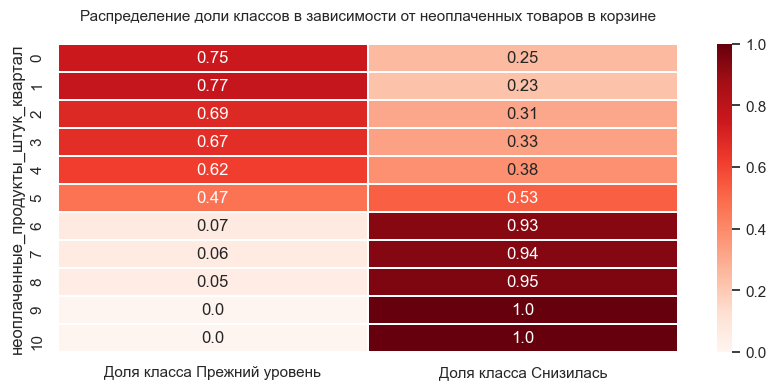

In [89]:
plt.figure(dpi=100, figsize=(10,4)) # размер, четкость
# группировка: по строкам - неоплаченные_продукты_штук_квартал,
# по столбцам - покупательская активность, агрегирующая функция - количество.
df = market_file.pivot_table(
    index='неоплаченные_продукты_штук_квартал',
    columns = 'покупательская_активность',
    aggfunc='count',
    values='разрешить_сообщать')
df = df.fillna(0)
df['Доля класса Прежний уровень'] = (
    df['Прежний уровень'] / (df['Прежний уровень'] + df['Снизилась'])).round(2)
df['Доля класса Снизилась'] = 1 - df['Доля класса Прежний уровень']
display(df)
# Заголовок
plt.title('Распределение доли классов в зависимости от неоплаченных товаров в корзине', y=1.05, fontsize=11);
# тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
sns.heatmap(
    data=df[
    ['Доля класса Прежний уровень', 'Доля класса Снизилась']
    ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='');

**Исследование покупательской активности в зависимости от общего числа неоплаченных товаров в корзине за последние 3 месяца:**   
Наибольшее снижение в относительных величинах пришлось на покупателей, имеющих от 6 до 10 товаров в корзине:
10 неоплаченных товаров - снижение 100% (4 чел.)           
9  неоплаченных товаров - снижение 100% (10 чел.)       
8  неоплаченных товаров - снижение 95% (19 чел.)       
7  неоплаченных товаров - снижение 94% (32 чел.)         
6  неоплаченных товаров - снижение 93% (41 чел.)         
5  неоплаченных товаров - снижение 53% (71 чел.)   
4  неоплаченных товара -  снижение 38% (75 чел.)       
3  неоплаченных товаров - снижение 33% (72 чел.)       
2  неоплаченных товаров - снижение 94% (32 чел.)         
1  неоплаченный товар -   снижение 23% (61 чел.)   
0  неоплаченный товаров - снижение 25% (29 чел.)  

**Подсчитаем, какой процент покупателей с количеством неоплаченных товаров более или равном 5 имеет снижение покупательской активности к общему числу покупателей со сниженной активностью.**

In [90]:
# количество покупателей класса Снизилась с количеством неоплаченных товаров более или равном 5
low = market_file[
    market_file['неоплаченные_продукты_штук_квартал'] >=5
]['покупательская_активность'].value_counts()['Снизилась']
# общее количество покупателей класса Снизилась
low_all = market_file['покупательская_активность'].value_counts()['Снизилась']
(low / low_all).round(2)

0.36

**Таким образом, 36% покупателей в классе "Снизилась" имеют неоплаченные товары за последний квартал в количестве более или равном 5.**    
Для стимулирования продаж интернет-магазину будет полезно напоминать покупателю, если он согласен на рассылку, что на товар в корзине действуют дополнительные скидки и количество оставшихся товаров.

### Исследовательский анализ данных. Датафрейм "market_money"

#### Исследование суммы выручки с покупателя за период

**Представим распределение выручки, которую получает магазин с покупателя, в виде диаграммы и ящика с усами для сравнения за разные периоды сначала без деления на классы по целевому признаку, затем - с делением.**    

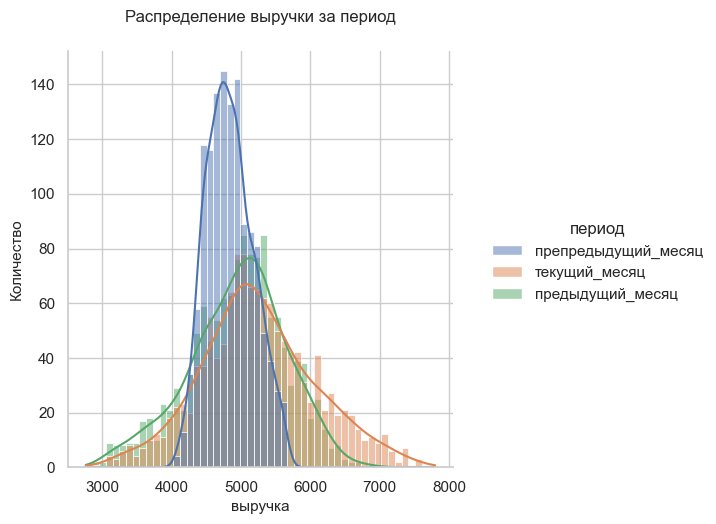

In [91]:
sns.displot(data=market_money, hue='период', kde=True, x='выручка');
# Подписи осей
plt.xlabel('выручка', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение выручки за период', y=1.05);

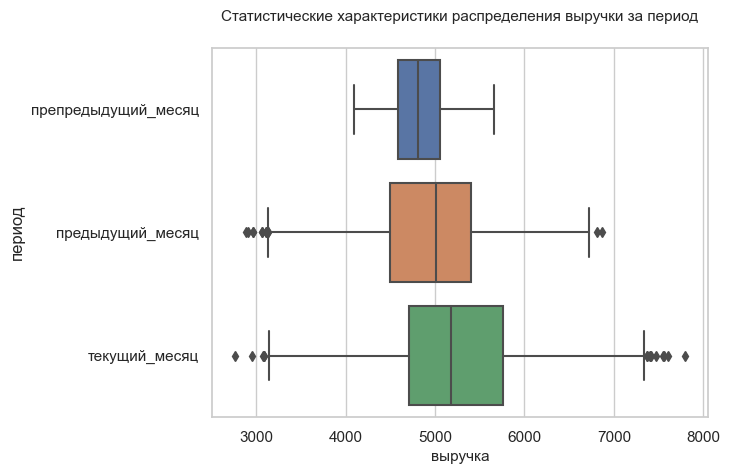

In [92]:
order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
sns.boxplot(x='выручка', y='период', data=market_money, showfliers=True, order=order); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения выручки за период', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('выручка', fontsize=11);

**Видим, что распределение выручки за препредыдущий месяц более сжато, а распределение выручки за текущий месяц имеет более широкий диапазон. Это говорит о том, что риски не получить плановую выручку с покупателя возросли. Медианное значение суммы выручки идет по нарастанию, так же как и риски. Вполне естественно: большему доходу соответствует больший риск.**

**Исследуем сумму выручки с покупателя по периодам в разрезе классов графически, но для наглядности также получим числовую таблицу по средней и общей выручке.**

In [93]:
# создаем датафрейм, содержащий выручку и покупательскую активность
df = market_money.set_index('id').join(market_file.set_index('id')[['покупательская_активность']])
# группируем по периодам и покупательской активности и рассчитываем аггрегирующие значения для столбца выручка
df.groupby(['период', 'покупательская_активность'])['выручка'].agg(['mean','median', 'sum', 'count'])

mean   median  \
период              покупательская_активность                         
предыдущий_месяц    Прежний уровень            4932.559227  4977.25   
                    Снизилась                  4971.674089  5052.75   
препредыдущий_месяц Прежний уровень            4933.475062  4927.00   
                    Снизилась                  4678.281377  4668.00   
текущий_месяц       Прежний уровень            5197.704115  5122.55   
                    Снизилась                  5303.671660  5293.65   

                                                     sum  count  
период              покупательская_активность                    
предыдущий_месяц    Прежний уровень            3955912.5    802  
                    Снизилась                  2456007.0    494  
препредыдущий_месяц Прежний уровень            3956647.0    802  
                    Снизилась                  2311071.0    494  
текущий_месяц       Прежний уровень            4168558.7    802  
                    Снизилась                  2620013.8    494

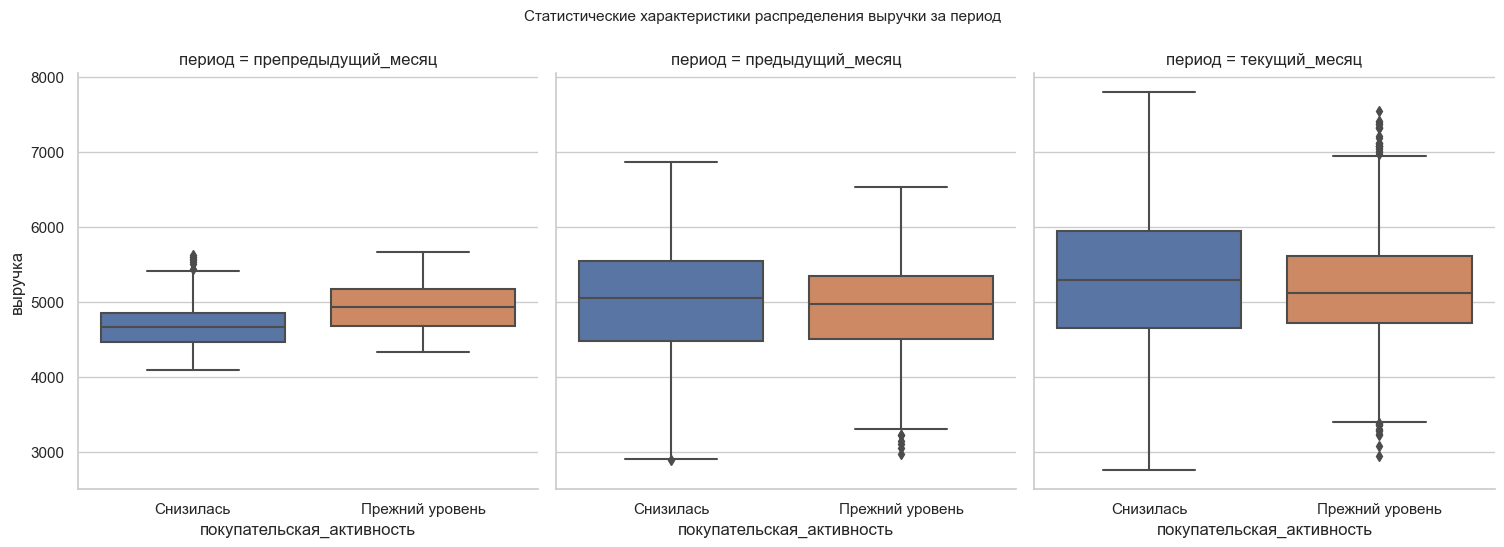

In [94]:
col_order = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
sns.catplot(data=df, y='выручка', x='покупательская_активность', col='период', kind='box', col_order=col_order);
# заголовок
plt.suptitle('Статистические характеристики распределения выручки за период', y=1.05, fontsize=11);

**Исследование выручки с покупателя по периодам в разрезе классов "Снизилась" и "Прежний уровень":**   
* **Препредыдущий период:**             
Распределение выручки более сжато по сравнению с другими периодами, то есть несет меньший риск недополучения выручки с покупателя для каждого из классов.    
В среднем выручка в этом периоде для класса "Прежний уровень" (медиана - 4927 руб., среднее - 4933 руб.) выше, чем для класса "Снизилась" (медиана - 4668 руб., среднее - 4678 руб.).    
* **Предыдущий период:**          
Распределение выручки стало иметь более широкие границы для каждого из классов, но для класса "Снизилась" границы шире, что говорит о большем риске недополучения запланированной выручки с покупателя.  При этом медианное значение суммы выручки в классе "Снизилась" (5053 руб.) выше, чем в классе "Прежний уровень" (4977 руб.).    
* **Текущий месяц:**        
В текущем месяце риски недополучения запланированной прибыли с покупателя возросли, что связано с большим разбросом значений вокруг средней выручки. Медианная выручка в текущем месяце выше для обоих классов по сравнению с предыдущими месяцами (5294 руб. для класса "Снизилась", 5123 руб. для класса "Прежний уровень"). Большему риску соответсвует больший доход. Медианная выручка в классе "Снизилась" ((5294 руб.) выше медианной выручки класса "Прежний уровень" (5123 руб.). 

### Исследовательский анализ данных. Датафрейм "market_time"

#### Исследование количества минут на сайте за период

**Представим распределение количества минут на сайте за период в виде гистограммы и ящика с усами для сравнения за разные периоды сначала без деления на классы по целевому признаку, затем - с делением.**    

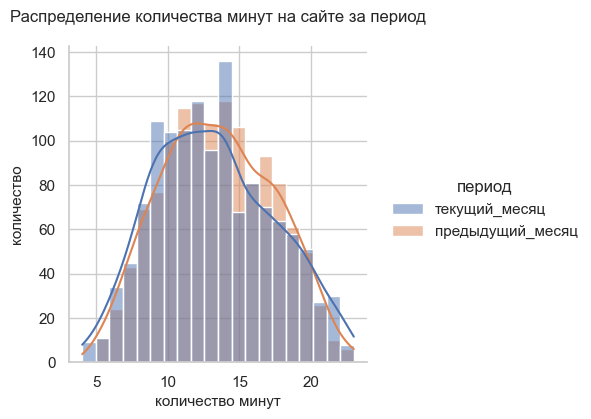

In [95]:
sns.displot(data=market_time, x='минут', hue='период', kde=True, bins=20, height=4, aspect=1);
# Подписи осей
plt.xlabel('количество минут', fontsize=11)
plt.ylabel('количество', fontsize=11)
# Заголовок
plt.title('Распределение количества минут на сайте за период', y=1.05);

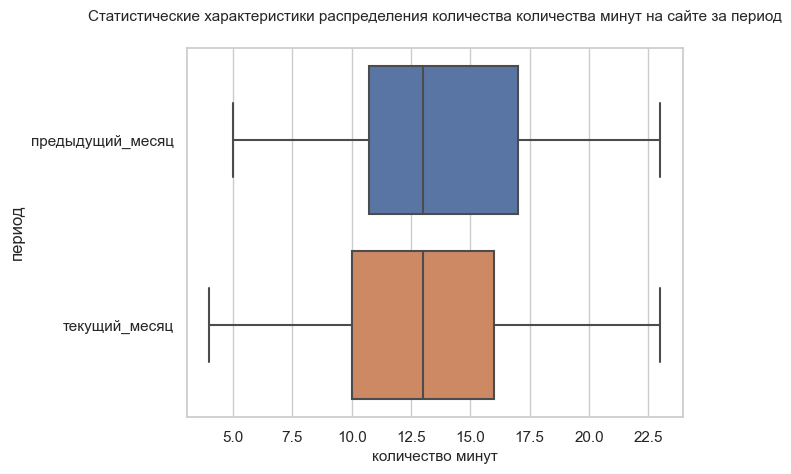

In [96]:
order = ['предыдущий_месяц', 'текущий_месяц']
sns.boxplot(x='минут', y='период', data=market_time, showfliers=True, order=order); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения количества количества минут на сайте за период', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('количество минут', fontsize=11);

In [97]:
# группировка по периодам, вычисление среднего, медианного, общего количества минут и указание количества объектов в периоде
market_time.groupby('период')['минут'].agg(['mean','median', 'sum', 'count'])

,mean,median,sum,count
период,,,,
предыдущий_месяц,13.470679,13,17458,1296
текущий_месяц,13.210648,13,17121,1296


**Распределение количества минут на сайте за текущий и предыдущий месяц имеет схожие характеристики. Медианное количество минут совпадает.**

**Исследуем количество минут на сайте, проведенных покупателем, по периодам в разрезе классов графически, но для наглядности также получим числовую таблицу по среднему и общему количеству минут.**

In [98]:
# создаем датафрейм, содержащий количество минут и покупательскую активность
df = market_time.set_index('id').join(market_file.set_index('id')[['покупательская_активность']])
# группируем по периодам и покупательской активности и рассчитываем аггрегирующие значения для столбца минут
df.groupby(['период', 'покупательская_активность'])['минут'].agg(['mean','median', 'sum', 'count', 'std'])

mean  median    sum  count  \
период           покупательская_активность                                    
предыдущий_месяц Прежний уровень            15.029925      15  12054    802   
                 Снизилась                  10.939271      10   5404    494   
текущий_месяц    Прежний уровень            14.604738      15  11713    802   
                 Снизилась                  10.947368      10   5408    494   

                                                 std  
период           покупательская_активность            
предыдущий_месяц Прежний уровень            3.352991  
                 Снизилась                  3.476428  
текущий_месяц    Прежний уровень            4.064355  
                 Снизилась                  3.418311

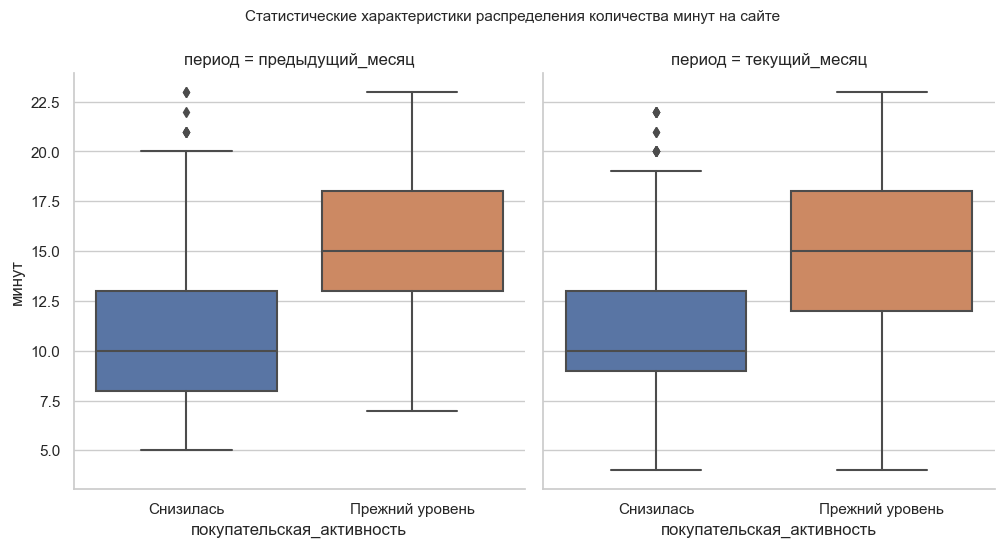

In [99]:
col_order = ['предыдущий_месяц', 'текущий_месяц']
sns.catplot(data=df, y='минут', x='покупательская_активность', col='период', kind='box', col_order=order);
# заголовок
plt.suptitle('Статистические характеристики распределения количества минут на сайте', y=1.05, fontsize=11);

**Исследование количества минут на сайте за период в разрезе классов "Снизилась" и "Прежний уровень":**
* Статистические характеристики количества минут на сайте для класса "Снизилась" за текущий и предыдущий месяц не сильно отличаются: медианное время совпадает (10 мин.), разброс значений вокруг среднего отличается незначительно (стандартное отклонение=3.48 мин. за предыдущий месяц и 3.42 мин. за текущий месяц).      
* Аналогично для класса "Прежний уровень": медианное время совпадает (15 мин.), разброс значений вокруг среднего в текущем месяце слегка возрос (стандартное отклонение=3.35 мин. за предыдущий месяц и 4.06 мин. за текущий месяц).   
* В среднем покупатели со сниженной покупательской активностью проводят меньше врени на сайте, чем покупатели с прежней активностью.

### Исследовательский анализ данных. Датафрейм "money"

#### Исследование распределения среднемесячной прибыли с покупателя за последние 3 месяца

In [100]:
# создаем датафрейм, содержащий прибыль и покупательскую активность
df = money.set_index('id').join(market_file.set_index('id')[['покупательская_активность']])
# группируем по покупательской активности и рассчитываем аггрегирующие значения для столбца прибыль
df.groupby(['покупательская_активность'])['прибыль'].agg(['mean','median', 'sum', 'count', 'std'])

,mean,median,sum,count,std
покупательская_активность,,,,,
Прежний уровень,3.995574,4.04,3204.45,802,1.032618
Снизилась,4.001154,4.05,1976.57,494,0.976446


Средние и медианные значения прибыли для классов "Снизилась" и "Прежний уровень" примерно одинаковы. При этом разброс значений вокруг средней выручки слегка выше для покупателей с прежней покупательской активностью.

**Представим распределение среднемесячной прибыли с покупателя за последние 3 месяца в виде гистограммы.**    

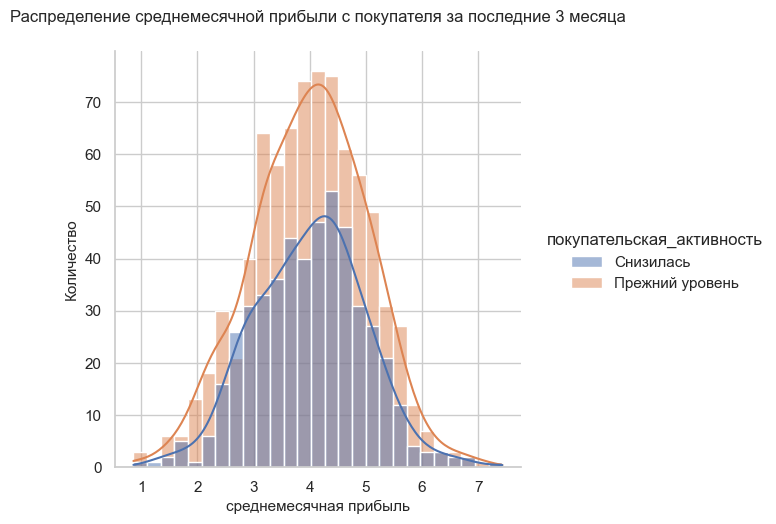

In [101]:
sns.displot(data=df, x='прибыль', hue='покупательская_активность', kde=True);
# Подписи осей
plt.xlabel('среднемесячная прибыль', fontsize=11)
plt.ylabel('Количество', fontsize=11)
# Заголовок
plt.title('Распределение среднемесячной прибыли с покупателя за последние 3 месяца', y=1.05);

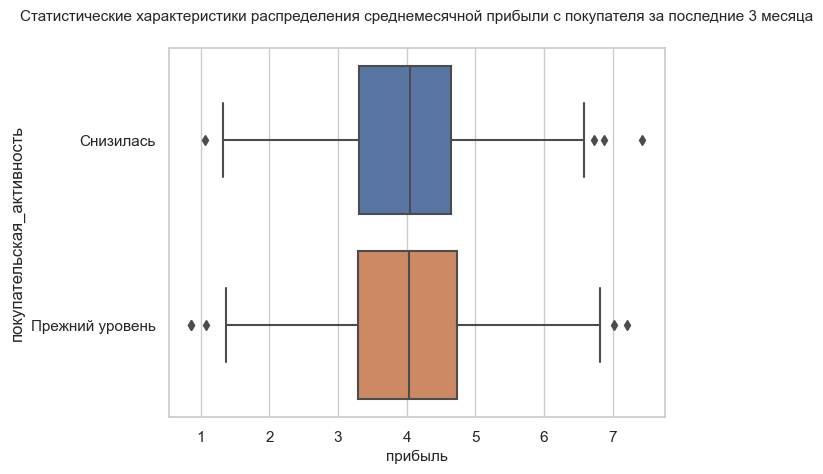

In [102]:
sns.boxplot(x='прибыль', data=df, y='покупательская_активность', showfliers=True); # ящик с усами
# заголовок
plt.title('Статистические характеристики распределения среднемесячной прибыли с покупателя за последние 3 месяца', y=1.05, fontsize=11);
# подпись оси
plt.xlabel('прибыль', fontsize=11);

По гистограмме и ящикам boxplot видно, что распределение прибыли для двух классов имеет схожие статистические характеристики: средние значения почти совпадают, разброс вокруг средней прибыли в классе "Прежний уровень" слегка выше (то есть слегка выше риск недополучения запланированной прибыли).   
По гистограмме видно, что класс "Прежний уровень" превосходит по количеству класс "Снизилась".

### Итоговый вывод по исследовательскому анализу данных

**Исследование класса покупательской активности:**    
Покупательская активность осталась на прежнем уровне у 802 покупателей (61.9%).    
Покупательская активность снизилась у 494 покупателей (38.1%).      

**Исследование типа сервиса:**    
922 покупателя (71.1%) относятся к сервису "стандарт".      
375 покупателей (28.9%) относятся к сервису "премиум".

**Исследование покупательской активности в зависимости от типа сервиса:**    
Для типа сервиса "премиум" 45% (168 покупателей) в классе "Снизилась", 55% (206 покупателей) в классе "Прежний уровень".         
Для типа сервиса "стандарт" 35% (326 покупателей) в классе "Снизилась", 65% (596 покупателей) в классе "Прежний уровень".

**Исследование популярной категории:**             
* Товары для детей - 329 покупателей (25.4%).
* Домашний текстиль - 250 покупателей (19.3%).
* Косметика и аксессуары - 223 покупателя (17.2%).
* Техника для красоты и здоровья - 182 покупателя (14%).
* Мелкая бытовая техника и электроника - 174 покупателя (13.4%).
* Кухонная посуда - 138 покупателей (10.6%).

**Исследование покупательской активности в зависимости от популярной категории:**    
  
*Наименьшее снижение в категориях:*
* "Мелкая бытовая техника и электроника" (16%, 27 покупателей).
* "Техника для красоты и здоровья" (27%, 50 покупатель).
   
*Наибольшее снижение в категориях:*
* "Кухонная посуда" (48%, 66 покупателей).
* "Косметика и аксессуары" (47%, 105 покупателей).
* "Товары для детей" (44%, 145 покупателей).
* "Домашний текстиль" (40%, 101 покупатель).

**Исследование признака согласия по рассылке:**              
* Согласны - 959 покупателей (74%).       
* Не согласны - 337 покупателей (26%).

**Исследование покупательской активности в зависимости от согласия покупателя на дополнительную рассылку о предложениях по товарам:**    
* Произошло одинаковое снижение покупательской активности (38%) в относительных величинах в классах разрешить сообщать и не разрешать сообщение.   
* Покупательская активность снизилась у 38% покупателей (368 человек) среди давших разрешение на отправку предложений о товаре.    
* Покупательская активность снизилась у 37% покупателей (126 человек) среди недавших разрешение на отправку предложений о товаре.  

**Исследование покупательской активности в зависимости от общего числа неоплаченных товаров в корзине за последние 3 месяца:**   
Наибольшее снижение в относительных величинах пришлось на покупателей, имеющих от 6 до 10 товаров в корзине:       
10 неоплаченных товаров - снижение 100% (4 чел.)           
9  неоплаченных товаров - снижение 100% (10 чел.)       
8  неоплаченных товаров - снижение 95% (19 чел.)       
7  неоплаченных товаров - снижение 94% (32 чел.)         
6  неоплаченных товаров - снижение 93% (41 чел.)         
5  неоплаченных товаров - снижение 53% (71 чел.)   
4  неоплаченных товара -  снижение 38% (75 чел.)       
3  неоплаченных товаров - снижение 33% (72 чел.)       
2  неоплаченных товаров - снижение 94% (32 чел.)         
1  неоплаченный товар -   снижение 23% (61 чел.)   
0  неоплаченный товаров - снижение 25% (29 чел.)  

**36% покупателей в классе "Снизилась" имеют неоплаченные товары за последний квартал в количестве более или равном 5.**    
Для стимулирования продаж интернет-магазину будет полезно напоминать покупателю, если он согласен на рассылку, что на товар в корзине действуют дополнительные скидки и количество оставшихся товаров.

**Исследование маркетинговых коммуникаций за последние 6 месяцев в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение маркетинговых коммуникаций в классе "Снизилась" - 3.9 меньше, чем в классе "Прежний уровень" (4.4).
- 25% покупателей с наименьшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 1.1 до 3.1, в классе "Прежний уровень" - от 2.1 до 4.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее число маркетинговых коммуникаций - от 3.1 до 4.4, в классе "Прежний уровень" - от 4 до 5.3.
- 25% покупателей с наибольшим средним числом маркетинговых коммуникаций в классе "Снизилась" - от 4.4 до 6.35, в классе "Прежний уровень" - от 5.3 до 6.6.           
**В классе "Снизилась" более широкий диапазон значений маркетинговых коммуникаций. В классе "Прежний уровень" более сжатое распределение маркетинговых коммуникаций.**   

**В среднем у покупателей со сниженной покупательской активностью меньшее значение маркетинговых коммуникаций, чем у покупателей с прежней покупательской активностью.**

**Исследование количества дней с момента регистрации покупателя на сайте в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества дней с момента регистрации покупателя на сайте в классе "Снизилась" - 637 больше, чем в классе "Прежний уровень" (590).
- 25% покупателей с наименьшим количеством дней с момента регистрации в классе "Снизилась" - от 121 до 449, в классе "Прежний уровень" - от 121 до 383.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют количество дней с момента регистрации - от 449 до 813, в классе "Прежний уровень" - от 383 до 799.
- 25% покупателей с наибольшим количеством дней с момента регистрации  в классе "Снизилась" - от 813 до 1079, в классе "Прежний уровень" - от 799 до 1061.         

**В среднем в классе "Снизилась" более давние клиенты по сравнению с классом "Прежний уровень".**

**При исследовании доли акционных покупок обнаружено 2 сегмента: с высокой и низкой долей акционных покупок. При этом в каждом сегменте есть представители 2 классов: Снизилась и Прежний уровень.**   
Снижение покупательской активности сильно затронуло сегмент с высокой долей акционных покупок, если рассматривать в относительных величинах. Однако, если рассматривать в абсолютных величинах, то сегмент с низкой долей акционных покупок имеет более высокое снижение покупательской активности. Ниже в цифрах.

**Исследование покупательской активности в зависимости от деления на сегменты по доли акционных покупок:**  

* В сегменте с высокой долей акционных покупок: покупательская активность снизилась в 80% случаев (133 покупателя), осталась на прежнем уровне - в 20% случаев (34 покупателя).     
* В сегменте с низкой долей акционных покупок: покупательская активность снизилась в 32% случаев (361 покупатель), осталась на прежнем уровне - в 68% случаев (768 покупателей). 

**Исследование акционных покупок без разбиения на сегменты по доле акционных покупок:**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.31 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.24, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.24 до 0.89, в классе "Прежний уровень" - от 0.15 до 0.26.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.89 до 0.99, в классе "Прежний уровень" - от 0.26 до 0.43.
В классе "Снизилась" более широкий диапазон значений доли акционных покупок. В классе "Прежний уровень" более сжатое распределение доли акционных покупок.   

**Исследование акционных покупок с разбиением на сегменты по доле акционных покупок:** 
* Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое распределение, при этом медианное значение примерно на одном уровне.
* Для сегмента с низкой долей акционных покупок для класса "Прежний уровень" меньшее медианное значение доли акционных покупок по сравнению с классом "Снизилась".
* **При этом есть часть клиентов с высокой долей акционных покупок, но при этом их покупательская активность не снижается.** Ниже в цифрах.    

**Исследование акционных покупок для сегмента с низкой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1129 экземпляров данных: 361 экземпляр данных - в классе "Снизилась", 768 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.28 больше, чем в классе "Прежний уровень" (0.21).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.11 до 0.22, в классе "Прежний уровень" - от 0.11 до 0.15.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.22 до 0.33, в классе "Прежний уровень" - от 0.15 до 0.25.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.33 до 0.4, в классе "Прежний уровень" - от 0.25 до 0.4.         
**В классе "Снизилась" более высокое медианное значение доли акционных покупок (0.28), чем в классе "Прежний уровень" (0.21)**.   

**Исследование акционных покупок для сегмента с высокой долей акционных покупок в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 167 экземпляров данных: 133 экземпляра данных - в классе "Снизилась", 34 экземпляров данных - в классе "Прежний уровень".
- Медианное значение доли акционных покупок в классе "Снизилась" - 0.94 меньше, чем в классе "Прежний уровень" (0.95).
- 25% покупателей с наименьшей долей акционных покупок в классе "Снизилась" - от 0.86 до 0.93, в классе "Прежний уровень" - от 0.92 до 0.94.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют долю акционных покупок - от 0.93 до 0.98, в классе "Прежний уровень" - от 0.94 до 0.95.
- 25% покупателей с наибольшей долей акционных покупок в классе "Снизилась" - от 0.98 до 0.99, в классе "Прежний уровень" - от 0.95 до 0.97.   
**Для сегмента с высокой долей акционных покупок для класса "Прежний уровень" - более сжатое распределение доли акционных покупок, для класса "Снизилась" - более широкое рапределение.**

**Исследование среднего количества просмотренных страниц за визит в разрезе классов "Снизилась" и "Прежний уровень":**   
- Результат получен на выборке из 1296 экземпляров данных: 494 экземпляра данных - в классе "Снизилась", 802 экземпляра данных - в классе "Прежний уровень".
- Медианное значение количества просмотренных страниц за визит в классе "Снизилась" - 5, что значительно меньше, чем в классе "Прежний уровень" (10).
- 25% покупателей с наименьшим средним количеством просмотренных страниц за визит в классе "Снизилась" - от 1 до 3, в классе "Прежний уровень" - от 3 до 7.
- 50% покупателей (серединные значения) в классе "Снизилась" имеют среднее количество просмотренных страниц за визит - от 0.3 до 7, в классе "Прежний уровень" - от 7 до 12.
- 25% покупателей с наибольшим количеством просмотренных страниц за визит в классе "Снизилась" - от 7 до 13, в классе "Прежний уровень" - от 12 до 19.    
**В среднем покупатели класса "Снизилась" имеют меньшее количество просмотренных страниц за визит, чем класса "Прежний уровень".**

**Исследование количества маркетинговых коммуникаций в текущем месяце  в разрезе классов "Снизилась" и "Прежний уровень":**       
В относительных величинах количество маркетинговых коммуникаций в разрезе классов "Снизилась" и "Прежний уровень" примерно одинаково. Однако в абсолютных величинах ввиду того, что класс "Прежний уровень" имеет значительно большее количество покупателей по сравнению с классом "Снизилась" - значения класса "Прежний уровень" значительно больше.    

**Исследование среднего количества просмотров категорий за визит в течение последнего месяца  в разрезе классов "Снизилась" и "Прежний уровень":**       
* В среднем среднее количество просмотров категорий за визит в классе  "Прежний уровень" выше, чем в классе "Снизилась". 
* В классе Снизилась первые 3 категории с наибольшим количеством просмотров - 2 (176 чел., 35.6%), 3 (132 чел., 26.7%), 1 (84 чел., 17%), а в классе  "Прежний уровень" - 3 (222 чел., 27.7%), 4 (200 чел., 24.9%), 5 (152 чел., 19%).

**Исследование общего числа неоплаченных товаров за последние 3 месяца в разрезе классов "Снизилась" и "Прежний уровень":**
* В классах "Снизилась" и "Прежний уровень" распределение неоплаченных товаров отличается.        
* Класс "Снизилась" более активно использует корзину для хранения интересующих товаров.
* В классе "Снизилась" примерно равномерное распределение на участке от 2 до 5 товаров в корзине: 2 товара - 80 чел., 15.6%, 3 товара - 72 чел., 14.6%, 4 товара - 75 чел., 15.2%, 5 товаров - 71 чел., 14.4%.
* Для класса "Прежний уровень" количество товаров в корзине с 1 до 8 идет на убывание: 1 товар - 200 чел., 24.9%, 2 товара - 178 чел., 22.2%, 3 товара - 145 чел., 18.1%, 4 товара - 122 чел., 15.2%, 5 товаров - 64 чел., 8%.
* Для каждого из классов есть покупатели, не имеющие неоплаченные товары в корзине: класс "Снизилась" - 29 чел., 5.9%, класс "Прежний уровень" - 87 чел., 10%.

**Во время посещения сайта у класса Прежний уровень возникает большее количество ошибок сервиса, чем у класса Снизилась. Это связано с большим количеством просмотренных страниц и категорий за визит, как было выяснено ранее.**

**Исследование количества минут на сайте за период в разрезе классов "Снизилась" и "Прежний уровень":**
* Статистические характеристики количества минут на сайте для класса "Снизилась" за текущий и предыдущий месяц не сильно отличаются: медианное время совпадает (10 мин.), разброс значений вокруг среднего отличается незначительно (стандартное отклонение=3.48 мин. за предыдущий месяц и 3.42 мин. за текущий месяц).      
* Аналогично для класса "Прежний уровень": медианное время совпадает (15 мин.), разброс значений вокруг среднего в текущем месяце слегка возрос (стандартное отклонение=3.35 мин. за предыдущий месяц и 4.06 мин. за текущий месяц).   
* В среднем покупатели со сниженной покупательской активностью проводят меньше врени на сайте, чем покупатели с прежней активностью.

**Исследование выручки с покупателя по периодам в разрезе классов "Снизилась" и "Прежний уровень":**   
* **Препредыдущий период:**             
Распределение выручки более сжато по сравнению с другими периодами, то есть несет меньший риск недополучения выручки с покупателя для каждого из классов.    
В среднем выручка в этом периоде для класса "Прежний уровень" (медиана - 4927 руб., среднее - 4933 руб.) выше, чем для класса "Снизилась" (медиана - 4668 руб., среднее - 4678 руб.).    
* **Предыдущий период:**          
Распределение выручки стало иметь более широкие границы для каждого из классов, но для класса "Снизилась" границы шире, что говорит о большем риске недополучения запланированной выручки с покупателя.  При этом медианное значение суммы выручки в классе "Снизилась" (5053 руб.) выше, чем в классе "Прежний уровень" (4977 руб.).    
* **Текущий месяц:**        
В текущем месяце риски недополучения запланированной прибыли с покупателя возросли, что связано с большим разбросом значений вокруг средней выручки. Медианная выручка в текущем месяце выше для обоих классов по сравнению с предыдущими месяцами (5294 руб. для класса "Снизилась", 5123 руб. для класса "Прежний уровень"). Большему риску соответсвует больший доход. Медианная выручка в классе "Снизилась" ((5294 руб.) выше медианной выручки класса "Прежний уровень" (5123 руб.). 

**Исследование прибыли в разрезе классов "Снизилась" и "Прежний уровень":**       
* Средние и медианные значения прибыли для классов "Снизилась" и "Прежний уровень" примерно одинаковы (среднее значение прибыли примерно 4 у.е. для обоих классов, медиана - 4.04 для класса "Снизилась" и 4.05 для класса "Прежний уровень").
* При этом разброс значений вокруг средней выручки слегка выше для покупателей с прежней покупательской активностью по сравнению с покупателями со сниженной покупательской активностью (1.03 у.е. против 0.98 у.е.).

## Объединение датафреймов market_file, market_money, market_time

### Преобразование таблиц market_money и market_time

Объединим таблицы market_file, market_money, market_time. Отметим, что размерности таблиц разные в связи с тем, что данные о выручке (market_money) и времени (market_time) на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода. Для этого вначале преобразуем таблицы market_money и market_time.

**Изменим таблицу "market_money". Посмотрим на ее размерность и внешний вид.**

In [103]:
market_money.shape

(3888, 3)

In [104]:
market_money.head(4)

,id,период,выручка
0,215349,препредыдущий_месяц,4472.0
1,215349,текущий_месяц,4971.6
2,215349,предыдущий_месяц,5216.0
3,215350,препредыдущий_месяц,4826.0


В таблице для каждого клиента дана выручка за 3 периода. Сделаем для каждого периода свой столбец с выручкой и удалим столбец "период". Для этого будем использовать сводные таблицы: в строках группируем по "id", в столбцах - по периоду, в качестве значений в таблице - выручка, в качестве агрегирующей функции можно взять first, last, mean - в нашем случае значение не поменяется, так как для одного покупателя 1 строка для каждого периода. Оставим по умолчанию mean.

In [105]:
market_money_new = market_money.pivot_table(index='id', columns='период', values='выручка')
market_money_new.head(3)

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4


**Переименуем столбцы, добавив слово "выручка" к каждому из периодов.**

In [106]:
# переименовывание столбцов через list comprehension
market_money_new.columns = ['_'.join(col) for col in zip(
    ['выручка']*len(market_money_new.columns.tolist()), 
    market_money_new.columns.tolist()
)]

In [107]:
# названия столбцов
market_money_new.columns

Index(['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц'],
      dtype='object')

In [108]:
market_money_new.head(3)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4


In [109]:
market_money_new.shape

(1296, 3)

**Аналогично изменим таблицу "market_time". Посмотрим на ее размерность и внешний вид.**

In [110]:
market_time.shape

(2592, 3)

In [111]:
market_time.head(3)

,id,период,минут
0,215349,текущий_месяц,10
1,215349,предыдущий_месяц,12
2,215350,текущий_месяц,13


В таблице "market_time" 2 периода и соответствующее им количество минут. По аналогии сделаем для каждого периода свой столбец с минутами и удалим столбец "период". Для этого будем использовать сводные таблицы: в строках группируем по "id", в столбцах - по периоду, в качестве значений в таблице - "минут", в качестве агрегирующей функции можно взять first, last, mean - в нашем случае значение не поменяется, так как для одного покупателя 1 строка для каждого периода. Оставим по умолчанию mean.

In [112]:
market_time_new = market_time.pivot_table(index='id', columns='период', values='минут')
market_time_new.head(3)

период,предыдущий_месяц,текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13


**Переименуем столбцы, добавив слово "минут" к каждому из периодов.**

In [113]:
# переименовывание столбцов через list comprehension
market_time_new.columns = ['_'.join(col) for col in zip(
    ['минут']*len(market_time_new.columns.tolist()), 
    market_time_new.columns.tolist()
)]

In [114]:
# названия столбцов
market_time_new.columns

Index(['минут_предыдущий_месяц', 'минут_текущий_месяц'], dtype='object')

In [115]:
market_time_new.head(3)

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13


In [116]:
market_time_new.shape

(1296, 2)

### Объединение датафреймов market_file, market_money, market_time

**Посмотрим на размерности датафреймов до объединения.**

In [117]:
market_file.shape, market_time_new.shape, market_money_new.shape

((1296, 14), (1296, 2), (1296, 3))

**Таблицы market_file, market_money_new, market_time_new имеют одинаковое количество строк. Однако проверим, есть ли в них отличающиеся id.**

In [118]:
# проверяем, что множество идентификаторов в таблицах одинаковое
set(market_time_new.index) == set(market_money_new.index) == set(market_file["id"])

True

**Мы проверили, что датафреймы содержат одинаковых покупателей (совпадают "id"). Объединим датафреймы по уникальному номеру id.**

In [119]:
market_file = market_file.set_index('id').join([market_money_new, market_time_new])
market_file.head(3)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,акционные_покупки_категории,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,высокая доля акционных покупок,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,низкая доля акционных покупок,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,высокая доля акционных покупок,6158.0,4793.0,6610.4,11,13


**Посмотрим на размерность датафрейма после объединения.**

In [120]:
market_file.shape

(1296, 18)

**Объединение прошло успешно, уменьшение на 1 столбец, так как "id" сделали индексом.**

### Промежуточный вывод по объединению датафреймов

Таблицы market_file, market_money, market_time объединены в одну.   
Перед объединением таблиц были сделаны следующие преобразования:
* На основе таблицы "market_money" создана таблица "market_money_new", в которой для каждого периода получен свой столбец с выручкой (выручка_предыдущий_месяц, выручка_препредыдущий_месяц, выручка_текущий_месяц) и удален столбец "период".
*  На основе таблицы "market_time" создана таблица "market_time_new", в которой для каждого периода получен свой столбец с минутами (минут_предыдущий_месяц, минут_текущий_месяц) и удален столбец "период".
*  Новые таблицы и "market_file" были проверены на соответствие покупателей по "id" и объединены по "id" в одну таблицу "market_file".
*  Объединенная таблица  "market_file" содержит 1296 строк, 17 столбцов (в качестве индекса установлен "id").

## Корреляционный анализ данных

**Для чего используют коэффициент корреляции:** чтобы определить направление и силу связи между переменными. Далее с учетом коэффициента корреляции и диаграмм рассеяния отбирают признаки для построения моделей машинного обучения. Отбирают признаки наиболее сильно коррелированные с целевой переменной. При этом, если между входными признаками присутствует мультиколлинеарность (корреляция между зависимыми переменными), исключают признак с меньшей корреляцией с целевой переменной. При мультиколлинеарности на целевую переменную оказывают эффект сразу несколько признаков и невозможно точно интерпретировать каждый из них. 

**Возникает вопрос, когда какой коэффициент корреляции использовать и для чего?**   
**[Какие методы и когда можно использовать:](https://www.dmitrymakarov.ru/opt/relationship-03/#26-podvedem-itog)**   
`Для двух количественных переменных:`   
* коэффициент Пирсона, если требуется оценить линейную зависимость   
* коэффициент Спирмена и Кендалла, если требуется оценить нелинейную зависимость.  
`Для двух категориальных переменных:`
* коэффициент Спирмена и Кендалла для порядковых категорий.
* коэффициент неопределенности Тиля           
`Для количественной и категориальной переменных:`
* точечно-бисериальный коэффициент корреляции, если категориальная переменная - дихотомическая (имеет 2 значения)
* корреляционное отношение в общем случае (в случае множества категорий).
          
При этом стоит отметить, что коэффициент корреляции Пирсона - это параметрический тест, то есть измеряет взаимосвязь количественных переменных в предположении, что обе переменные имеют нормальное распределение. Коэффициенты Спирмена и Кендалла - непараметрические тесты, то есть не предполагают каких-либо допущений о распределении генеральной совокупности, из которой взяты выборки. На практике это означает, что, если допущения параметрического теста не выполняются, его результат нельзя считать достоверным. Для непаметрического теста такое допущение отсутствует.

Таким образом для переменных разного типа с разным распределением используется разная методология расчета коэффициента корреляции. Это усложняет корреляционный анализ. Однако на текущий момент разработан новый коэффициент корреляции [phi_K для расчета матрицы корреляций переменных смешанного типа](https://arxiv.org/abs/1811.11440).

phi_K - практический коэффициент корреляции, основанный на нескольких уточнениях проверки гипотезы Пирсона о независимости двух переменных. Объединенные функции  phi_K формируют преимущество перед существующими коэффициентами. Во-первых, он работает согласованно между категориальными, порядковыми и интервальными переменными. Во-вторых, он фиксирует нелинейную зависимость. В-третьих, он возвращается к коэффициенту корреляции Пирсона в случае двунаправленного нормального входного распределения. Это полезные функции при изучении корреляции между переменными смешанных типов. Особое внимание уделяется надлежащей оценке статистической значимости корреляций. Реализован в библиотеке Python - [phik.](https://nbviewer.org/github/KaveIO/PhiK/blob/master/phik/notebooks/phik_tutorial_basic.ipynb)

**Наша цель - построение моделей машинного обучения, поэтому отбор признаков и проверку [мультиколлинеарности](https://www.dmitrymakarov.ru/opt/mlr-04/#10-4-otsutstvie-multikollinearnosti) проведем с помощью коэффициентов корреляции  phi_K.**     
**Этот анализ поможет нам в случае добавления признаков в модель либо их удаления из модели.**

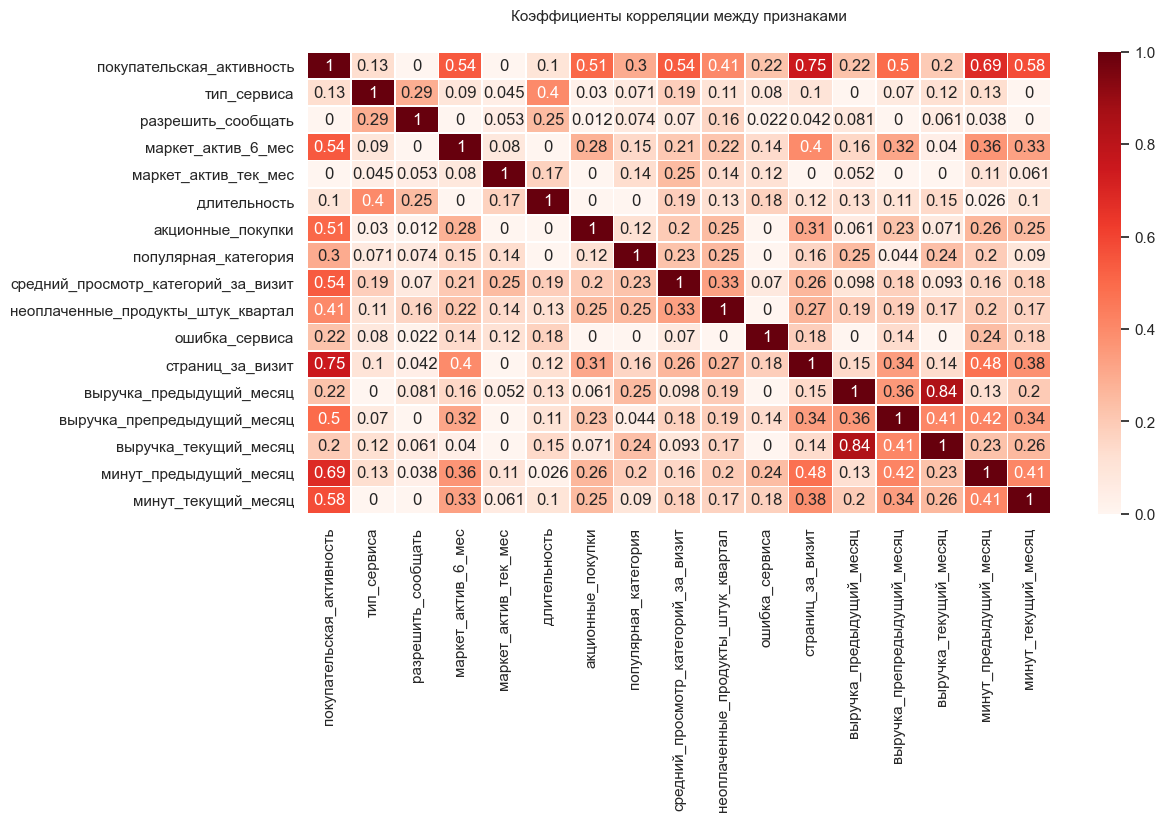

In [121]:
# задаем размер и четкость-количество точек на дюйм
plt.figure(dpi=100, figsize=(12,6))
# Заголовок
plt.title('Коэффициенты корреляции между признаками', y=1.05, fontsize=11);
# столбцы с непрерывными переменными
interval_cols = ['маркет_актив_6_мес', 'длительность', \
'акционные_покупки', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', \
'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
# визуализация с помощью тепловой карты
sns.heatmap(market_file.drop(columns='акционные_покупки_категории').phik_matrix(interval_cols=interval_cols), \
            linewidth=0.5, cmap='Reds', annot=True);

Посмотрим, какие признаки влияют на целевую переменную более всего.

**Взаимосвязь между целевым (покупательская_активность) и входными признаками.**         
**Показатели коррелированности по [шкале Чеддока](https://math.semestr.ru/corel/cheddok.php):**     
**Весьма высокая (0.9-1):**      
- нет.     
**Высокая корреляция (0.7-0.9):**       
- между покупательской активностью и средним количеством просмотренных страниц за визит (коэффициент корреляции 0.75).       
**Заметная корреляция (0.5-0.7):**             
- между покупательской активностью и количеством минут на сайте за предыдущий месяц (коэффициент корреляции 0.69).      
- между покупательской активностью и количеством минут на сайте за текущий месяц (коэффициент корреляции 0.58).             
- между покупательской активностью и средним просмотром категорий за визит в течение последнего месяца (коэффициент корреляции 0.54).              
- между покупательской активностью и средним значением маркетинговых коммуникаций за последние 6 месяцев (коэффициент корреляции 0.54).             
- между покупательской активностью и среднемесячной долей акционных покупок за последние 6 месяцев (коэффициент корреляции 0.51).          
- между покупательской активностью и суммой выручки за препредыдущий месяц (коэффициент корреляции 0.5) - граничное значение между умеренной и заметной корреляцией.         
**Умеренная корреляция (0.3-0.5):**               
- между покупательской активностью и общим числом неоплаченных товаров за последние 3 месяца (коэффициент корреляции 0.41).         
- между покупательской активностью и популярной категорией за последние 6 месяцев (коэффициент корреляции 0.3) - граничное значение между слабой и умеренной корреляцией.         
**Слабая корреляция (0.1-0.3):**                  
- между покупательской активностью и суммой выручки за предыдущий месяц (коэффициент корреляции 0.22).      
- между покупательской активностью и количеством сбоев во время посещения сайта (ошибка_сервиса) (коэффициент корреляции 0.22).          
- между покупательской активностью и суммой выручки за текущий месяц (коэффициент корреляции 0.2).           
- между покупательской активностью и типом сервиса (коэффициент корреляции 0.13).           
- между покупательской активностью и количеством дней с момента регистрации покупателя на сайте (коэффициент корреляции 0.1) -  граничное значение между "практически отсутствует" и слабой корреляцией.              
**Практически отсутствует (0-0.1):**                  
- между покупательской активностью и количество маркетинговых коммуникаций в текущем месяце (коэффициент корреляции 0).       
- между покупательской активностью и согласием покупателя на рассылку (разрешить_сообщать) (коэффициент корреляции 0).         

**Посмотрим, как связаны между собой входные признаки.**

**`Распределим коэффициенты корреляции между входными признаками в группы, начиная с коэффициента корреляции 0.7 и выше.`**    
**Показатели коррелированности по [шкале Чеддока](https://math.semestr.ru/corel/cheddok.php):**     
**Весьма высокая (0.9-1):**      
- нет.     
**Высокая корреляция (0.7-0.9):**
- между выручкой за предыдущий месяц и выручкой за текущий месяц (коэффициент корреляции 0.84).     

* **Как правило, о мультиколинеарности (высокой корреляции между зависимыми переменными) говорят `при коэффициенте корреляции от 0.9 и выше по модулю`. И это относится к числовым переменным, то есть между ними можно построить линейную зависимость.** В такой ситуации лишние коррелирующие признаки необходимо удалить из обучающей выборки.
* Сильно коррелированные друг с другом переменные дают модели одну и ту же информацию. Следовательно, для анализа не нужно использовать их все. В таком случае в модели нужна только одна из таких переменных.
* Однако также может случиться, что несколько переменных с высокой корреляцией фактически добавляют информацию, которая должна быть использована. 
* В нащем случае, **между выручкой за предыдущий месяц и выручкой за текущий месяц (коэффициент корреляции 0.84) существует сильная зависимость. Будет ли она помехой при построении моделей машинного обучения проверим далее, построив модели с этими признаками вместе и с каждым из них по-отдельности.**

Некоторые эксперты отмечают, что **мультиколлинеарность может возникать [при коэффициентах корреляции > 0.7](https://yandex.ru/q/machine-learning/9208212225/).** Диагностировать мультиколлинеарность можно 2 способами: 
* [заметные изменения в расчетных коэффициентах регрессии путем добавления или удаления входного признака ](https://yandex.ru/q/machine-learning/9208212225/)
* [коэффициент увеличения дисперсии VIF позволяет выявить корреляцию между признаками модели](https://www.dmitrymakarov.ru/opt/mlr-04/#11-variance-inflation-factor)